

![image-20201226152702981](images/image-20201226152702981.png)

## 获取数据

首先引入需要的包。

In [1]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [3]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr



output_path = os.path.abspath('./output')
data_name = 'stack-overflow-16k'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['csharp', 'java', 'javascript', 'python']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'text_columns': 'snps_sa_comments',
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'stop_words':stopwords.words('english'),
    'batch_size': 32,    
    'max_features': 10000,
    'sequence_length': 500,    
    'epochs': 3,    
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':True,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.6, 'layer_count':1, 'units':256, 'epochs':15},
        'rnn':{'dropout':0.4, 'embedding_dim':200, 'units':200, 'epochs':5},
        'embedding':{'dropout':0.4, 'embedding_dim':200, 'epochs':15},
        'sepcnn':{'dropout':0.4, 'epochs': 10, 'batch_size':128},
        'tl':{'dropout':0.4, 'trainable':True, 'layer_count':1, 'unit':64, 'epochs': 10},
        'pg':{'dropout':0.4, 'embedding_dim':300, 'units':80, 'epochs':20, 'learning_rate':0.0005},  
    },
    'embedding_paths':{
        'cc_en_300':os.path.join(word_vectors_path, 'snps', 'cc.en.300.vec'),
        'fasttext_crawl_300d_2M':os.path.join(word_vectors_path, 'fasttext-crawl-300d-2M.vec'),
        'glove_twitter_27B_200d':os.path.join(word_vectors_path, 'glove.twitter.27B.200d.txt')
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

### 下载数据

开始下载数据。

In [4]:
dataset_dir =  os.path.join(os.path.expanduser('~'), '.keras/datasets/stack_overflow_16k') 
if not os.path.exists(dataset_dir):
    url = "http://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz"
    dataset = tf.keras.utils.get_file("stack_overflow_16k.tar.gz", url, untar=True, 
                                      cache_subdir='datasets/stack_overflow_16k')
print(dataset_dir)

/root/.keras/datasets/stack_overflow_16k


In [5]:
qbz95.utils.show_tree(dataset_dir, max_depth=2)

2021-07-21 08:19:55,958: INFO: /root/.keras/datasets/stack_overflow_16k
2021-07-21 08:19:55,960: INFO: ├──stack_overflow_16k.tar.gz.tar.gz
2021-07-21 08:19:55,960: INFO: ├──README.md
2021-07-21 08:19:55,961: INFO: ├──train
2021-07-21 08:19:55,961: INFO: │   ├──python
2021-07-21 08:19:55,962: INFO: │   ├──java
2021-07-21 08:19:55,963: INFO: │   ├──csharp
2021-07-21 08:19:55,963: INFO: │   └──javascript
2021-07-21 08:19:55,964: INFO: └──test
2021-07-21 08:19:55,965: INFO:     ├──python
2021-07-21 08:19:55,965: INFO:     ├──java
2021-07-21 08:19:55,966: INFO:     ├──csharp
2021-07-21 08:19:55,967: INFO:     └──javascript




### 查看数据

下面看一看实际的数据是啥样的。

In [6]:
def get_files(base_dir):
    files = {}
    for folder in os.listdir(base_dir):
        class_dir = os.path.join(base_dir, folder)
        text_files = os.listdir(class_dir)
        files[folder] = [os.path.join(class_dir, file_name) for file_name in text_files]    
    return files

def show_files(files, title=''):
    print('-'*40, title, '-'*40)
    for class_dir, text_files in files.items():
        print('{}: {} files'.format(class_dir, len(text_files)))
        

train_files = get_files(os.path.join(dataset_dir, 'train'))
test_files = get_files(os.path.join(dataset_dir, 'test'))    
    
show_files(train_files, 'train')
show_files(test_files, 'test')

---------------------------------------- train ----------------------------------------
python: 2000 files
java: 2000 files
csharp: 2000 files
javascript: 2000 files
---------------------------------------- test ----------------------------------------
python: 2000 files
java: 2000 files
csharp: 2000 files
javascript: 2000 files


看一看具体的数据

In [7]:
for class_dir, text_files in train_files.items():
    print('='*40, class_dir, '='*40)
    for file_path in text_files[0:2]:    
        print('-'*30 + os.path.basename(file_path) + '-'*30 )
        with open(file_path) as f:
            comment = f.read() 
            print(comment if len(comment)<=800 else comment[0:800]+' ...') 

======================================== python ========================================
------------------------------1053.txt------------------------------
"how to put multiple pickles files in a single pickle file i have two pickle files that are contain a list of numpy ndarrays...first pickle file:..{'encodings': [array([-0.18668848,  0.09167872,  0.02361359, -0.04610855, -0.11987427,.       -0.06734911,  0.00542389,  0.02105863,  0.17828396, -0.00141097,.        0.166828s45, -0.01075029, -0.20508201,  0.02762154, -0.00806585,.        0.098497  , -0.17736666, -0.11334869, -0.10142692, -0.1134191 ,.        0.06917755,  0.07989676, -0.04121129,  0.04280601, -0.12306173,.       -0.29819348, -0.07650399, -0.10041754,  0.02334423, -0.06270325,.        0.12638046,  0.10296188, -0.10587093, -0.08311734,  0.06213638,.        0.08304631, -0.03443629, -0.08486824,  0.23685798,  0.01827276,.       -0.10278646,  0.01152256,  0.08467054,  0.37257931,  0 ...
------------------------------1735.tx



## 探索数据

接下来，对把数据加载进内存，进行深入一些的探索。

### 基本信息

In [8]:
def get_samples(texts, labels, rate):
    indexs = np.arange(len(texts))
    sample_indexs, _, sample_labels, _ = train_test_split(indexs, labels,                                                          
                                                          test_size=1-rate,
                                                          random_state=12)
    sample_texts = [texts[index] for index in sample_indexs]
    return sample_texts, sample_labels    

def load_stack_overflow_16k_dataset(data_path, classes=params.classes, seed=123):
    def load_data(base_dir):
        texts = []
        labels = []
        for category in os.listdir(base_dir):
            category_path = os.path.join(base_dir, category)
            for fname in sorted(os.listdir(category_path)):
                if fname.endswith('.txt'):
                    with open(os.path.join(category_path, fname)) as f:
                        texts.append(f.read())
                    labels.append(classes.index(category) )
        return texts, labels

    train_texts, train_labels = load_data(os.path.join(data_path, 'train'))
    test_texts, test_labels = load_data(os.path.join(data_path, 'test'))

    # Shuffle the training data and labels.
    random.seed(seed)
    random.shuffle(train_texts)
    random.seed(seed)
    random.shuffle(train_labels)

    return ((train_texts, np.array(train_labels)),
            (test_texts, np.array(test_labels)))

(train_texts, train_labels), (test_texts, test_labels) = load_stack_overflow_16k_dataset(dataset_dir)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

if params.sample_perecent<1:
    train_texts, train_labels = get_samples(train_texts, train_labels, rate=params.sample_perecent)
    test_texts, test_labels = get_samples(test_texts, test_labels, rate=params.sample_perecent)

print('train_texts.length={}, train_labels.shape={}'.format(len(train_texts), train_labels.shape))
print('test_texts.length={}, test_labels.shape={}'.format(len(test_texts), test_labels.shape))

train_texts.length=8000, train_labels.shape=(8000,)
test_texts.length=8000, test_labels.shape=(8000,)
train_texts.length=8000, train_labels.shape=(8000,)
test_texts.length=8000, test_labels.shape=(8000,)


In [9]:
test_texts[0]

'"variables keep changing back to their original value inside a while loop i am doing the mitx 6.00.01x course and i am on the second problem set on the 3rd problem and i am stuck. .my code:  ..    balance = 320000.    annualinterestrate = 0.2.    monthlyinterestrate = (annualinterestrate) / 12.0.    monthlyfixedpayment = 0.    empbalance = balance.    lowerbound = round((balance)/12,2).    upperbound = (balance*(1+monthlyinterestrate)**12)/12.    monthlyfixedpayment = round( ( (lowerbound+upperbound)/2) ,2).    while tempbalance != 0: .        monthlyfixedpayment = round( ( (lowerbound+upperbound)/2) ,2)  .        for m in range(12) :.            tempbalance -= monthlyfixedpayment .            tempbalance += (monthlyinterestrate)*(tempbalance).            tempbalance = round(tempbalance,2) .        if tempbalance &gt; 0:.            lowerbound = round(monthlyfixedpayment,2).            tempbalance = balance.        elif tempbalance &lt; 0: .            upperbound = round(monthlyfixedp

### 类别分布

下面看看类别的分布。可以看到数据分为Positive和Negative两类，数据分布完全均匀。

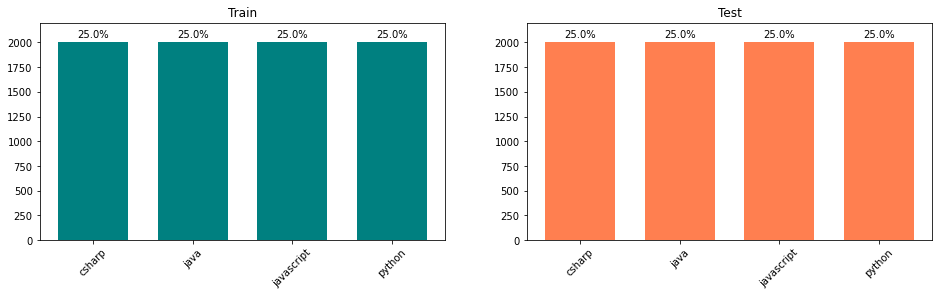

In [48]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



### 文本长度分布

分析训练集和测试集的文本长度分布是否相似。

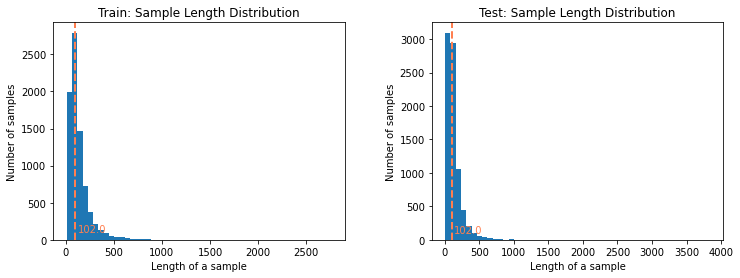

train：mean=137.06 variance=16491.97
test：mean=133.22 variance=14516.98


In [11]:
train_text_lengths = [len(s.split()) for s in train_texts]
test_text_lengths = [len(s.split()) for s in test_texts]
qtf.utils.plot_length_distribution(train_text_lengths, test_text_lengths)

print('train：mean={:0.2f} variance={:0.2f}'.format(np.mean(train_text_lengths), 
                                                    np.var(train_text_lengths)))
print('test：mean={:0.2f} variance={:0.2f}'.format(np.mean(test_text_lengths), 
                                                   np.var(test_text_lengths)))


通过图形，中位数，均值和方差的比较，可以认为训练集和测试集文本长度的分布是非常相似的。下面用卡方检验来比较训练集和测试集是否有显著差异。

In [12]:
def process_length(lengths):
    cut_points = [0,99,199,299,399,499,599,699,799,10000]
    labels = ["0-99","100-199","200-299","300-399","400-499","500-599", "600-699","700-799","800+"]
    return pd.cut(lengths, cut_points, labels=labels)

def get_observed(df, column1, column2):
    df_observed = pd.crosstab(
        df[column1],
        df[column2]
    )    
    return df_observed
    
def get_expected(df_observed):
    observed = df_observed.to_numpy()
    reduce_row = observed.sum(axis=0, keepdims=True)/observed.sum()
    reduce_col = observed.sum(axis=1, keepdims=True)

    expected = reduce_col.dot(reduce_row)
    df_expected = pd.DataFrame(expected, index=df_observed.index, columns=df_observed.columns)
    return df_expected
  
def show_sum(df):
    df.columns =  df.columns.tolist()  
    df = df.reset_index()
    s = df.melt(df.columns[0], var_name=' ')
    ct = pd.crosstab(index=s[df.columns[0]], columns=s.iloc[:,1], values=s.value, 
                     aggfunc='sum', margins=True, margins_name='合计',
                     rownames=[''], 
               ) 
    display(ct)
    
length = train_text_lengths + test_text_lengths
dataset = ['train']*len(train_text_lengths) + ['test']*len(test_text_lengths)

df_length = pd.DataFrame({"dataset":dataset, "length":length})
df_length['len'] = process_length(length)
df_observed = get_observed(df_length, 'dataset', 'len')
# display(df_length)

print('-'*25, 'Observed', '-'*25)
show_sum(df_observed)

print('-'*25, 'Expected', '-'*25)
df_expected = get_expected(df_observed)
show_sum(df_expected)

------------------------- Observed -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,3868,2836,772,283,113,54,36,12,26,8000
train,3885,2742,782,295,131,68,38,22,37,8000
合计,7753,5578,1554,578,244,122,74,34,63,16000


------------------------- Expected -------------------------


,0-99,100-199,200-299,300-399,400-499,500-599,600-699,700-799,800+,合计
,,,,,,,,,,
test,3876.5,2789.0,777.0,289.0,122.0,61.0,37.0,17.0,31.5,8000.0
train,3876.5,2789.0,777.0,289.0,122.0,61.0,37.0,17.0,31.5,8000.0
合计,7753.0,5578.0,1554.0,578.0,244.0,122.0,74.0,34.0,63.0,16000.0


![image-20210101174143400](images/image-20210101174143400.png)

然后进行卡方检验。可以看到p_value>0.05，所以接受原假设——数据集来源和文本长度是独立的，也就是说接受训练集和测试集是是相似的分布。

In [13]:
observed = df_observed.to_numpy()
expected = df_expected.to_numpy()

chi_squared_stat = ((observed-expected)**2/expected).sum()
print('chi_squared_stat =', chi_squared_stat)

df = np.prod(np.array(observed.shape) - 1)
critical_value  = stats.chi2.ppf(q=0.95, df=df)  #0.95:置信水平, df:自由度
print('critical_value =', critical_value)        #临界值:拒绝域的边界, 当卡方值大于临界值，则原假设不成立，备择假设成立

p_value = 1 - stats.chi2.cdf(x=chi_squared_stat, df=df)
print('p_value =', p_value)

chi_squared_stat = 9.785132895960267
critical_value = 15.50731305586545
p_value = 0.2804318778573175



### 词频分布

分析训练集和测试集的词频分布是否相似。下面代码中，去除了一些stopwords。

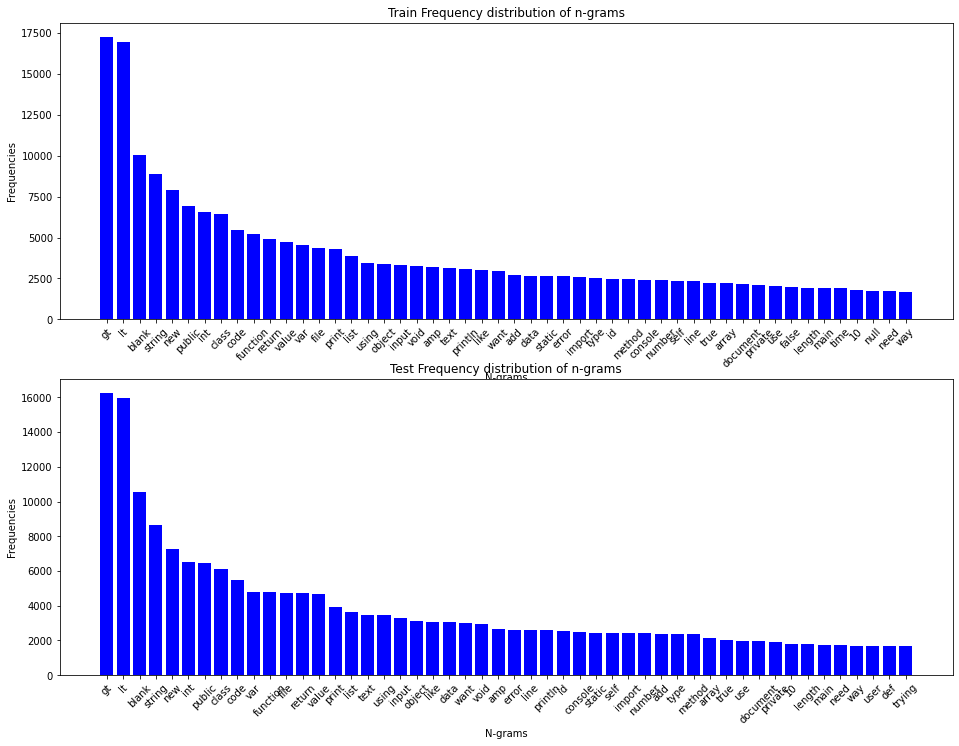

In [14]:
qtf.utils.plot_frequency_distribution(train_texts, test_texts) 

In [15]:
word_counter = Counter()
for s in train_texts:
    word_counter.update(s.split())
for s in test_texts:
    word_counter.update(s.split())   

print('Number of Vocabulary: {}'.format(len(word_counter)))

for word in list(word_counter):
    if word_counter[word]<25: word_counter.pop(word)
        
print('Number of Vocabulary: {}'.format(len(word_counter)))

Number of Vocabulary: 337733
Number of Vocabulary: 4670


![image-20201217142728260](images/image-20201217142728260.png)

上面可以看到词频大于等于100次的词汇有7706个。

## 准备数据

不同的模型需要准备不同的数据，所以徐要确定一下要构建哪种模型。

### 模型选择

下图是google在两年前提出一个选择流程图。

![image-20201217135347743](images/image-20201217135347743.png)

1. Calculate the number of samples/number of words per sample ratio.
2. If this ratio is less than 1500, tokenize the text as n-grams and use a simple multi-layer perceptron (MLP) model to classify them (left branch in the flowchart below):
   a. Split the samples into word n-grams; convert the n-grams into vectors.
     b. Score the importance of the vectors and then select the top 20K using the scores.
   c. Build an MLP model.
3. If the ratio is greater than 1500, tokenize the text as sequences and use a sepCNN model to classify them (right branch in the flowchart below):
   a. Split the samples into words; select the top 20K words based on their frequency.
   b. Convert the samples into word sequence vectors.
   c. If the original number of samples/number of words per sample ratio is less   than 15K, using a fine-tuned pre-trained embedding with the sepCNN  model will likely provide the best results.
4. Measure the model performance with different hyperparameter values to find
   the best model configuration for the dataset.

In [16]:
length_median = np.median(train_text_lengths)
train_number = len(train_texts)
print ("[the number of samples]/[number of words per sample] = {:0.1f}".format(train_number/length_median))

[the number of samples]/[number of words per sample] = 78.4


可以看到这个比例大大小于15k，所以我们从N-gram模型开始，但是同时我们也会为Sequence模型准备数据。数据准备有如下几个过程。
1. Standardization 
   
   文本标准化操作，去除一些不合规范的字符或单词等。比如：去除拼音和HTML标记
   
   
2. Tokenization

   把文本字符串拆分成Token。对于英文最常见的拆分方式是根据空格拆分
   
   
3. Vectorization

   把Token转化为向量。
   

接下来，我们将分别为N-gram模型和Sequence模型准备数据。

### N-gram + Preprocess

在N-gram模型中，Tokenization一般使用unigrams + bigrams的方式把文本转成Token，而Vectorization过程，一般先统计Token的BOW（Bag of Words，词袋模型），然后采用tf-idf在对词频进行平衡。

In [17]:
stop_words = params.stop_words if params.use_stop_words else None
generator = qtf.text.NgramGenerator('ngram_preproess', standardize=qtf.text.standardize_text1,
                                    texts=train_texts, labels=train_labels, max_feature=params.max_features, 
                                    stop_words=stop_words)
ngram_datasets1 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                              generator=generator, batch_size=params.batch_size)

In [18]:
data, labels = iter(ngram_datasets1.train_dataset).next()
print(type(data))
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(tf.sparse.to_dense(data), labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(np.any(item.numpy()>0), item.shape)

<class 'tensorflow.python.framework.sparse_tensor.SparseTensor'>
(32, 10000) (32,)
---------------------------------------- csharp ----------------------------------------
True (10000,)
---------------------------------------- javascript ----------------------------------------
True (10000,)
---------------------------------------- javascript ----------------------------------------
True (10000,)
---------------------------------------- java ----------------------------------------
True (10000,)
---------------------------------------- javascript ----------------------------------------
True (10000,)


### Sequence + Preprocess

In [19]:
generator = qtf.text.SequenceGenerator('sequence_prepross', standardize=qtf.text.standardize_text1, 
                                       texts=train_texts, max_features=params.max_features, 
                                       max_sequence_length=params.sequence_length)
sequence_datasets1 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                                 generator=generator, batch_size=params.batch_size) 

In [20]:
data, labels = iter(sequence_datasets1.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 500) (32,)
---------------------------------------- java ----------------------------------------
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0

### N-gram + Process

In [21]:
generator = qtf.text.LayerGenerator.get_ngram_layer(name='ngram_map', standardize=qtf.text.standardize_tf_text1, 
                                                        texts=train_texts, max_features=params.max_features)
ngram_datasets2 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels, 
                                              generator=generator, batch_size=params.batch_size)

In [22]:
data, labels = iter(ngram_datasets2.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 10000) (32,)
---------------------------------------- python ----------------------------------------
[477.28156     3.6241884   2.3127925 ...   0.          0.
   0.       ] (10000,)
---------------------------------------- javascript ----------------------------------------
[3.5439526e+03 2.1745129e+00 1.5418617e+00 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] (10000,)
---------------------------------------- python ----------------------------------------
[3.2257649e+03 2.8993506e+00 2.4669786e+01 ... 0.0000000e+00 0.0000000e+00
 0.0000000e+00] (10000,)
---------------------------------------- python ----------------------------------------
[899.7031      3.6241884   9.25117   ...   0.          6.590676
   0.       ] (10000,)
---------------------------------------- csharp ----------------------------------------
[318.1877      2.1745129   3.854654  ...   0.          0.
   0.       ] (10000,)


### Sequence + Process

![Embedding Layer](images/EmbeddingLayer.png)

如上图所示，和N-gram模型不同，Sequence模型并不统计词频，它保持了文本的原始顺序，把其中的每个词汇单独变成一个One-hot向量，然后采用Word embedding的方式生成更加有意义的词向量，最后输出到RNN，CNN等模型中。

In [23]:
generator = qtf.text.LayerGenerator.get_sequence_layer(name='sequence_map', 
                                                       standardize=qtf.text.standardize_tf_text1, 
                                                       texts=train_texts, 
                                                       max_features=params.max_features,
                                                       max_sequence_length=params.sequence_length)
sequence_datasets2 = qtf.classification.Datasets(train_texts, train_labels, test_texts, test_labels,   
                                                 generator=generator, batch_size=params.batch_size)

In [24]:
data, labels = iter(sequence_datasets2.train_dataset).next()
print(data.shape, labels.shape)

for i, (item, label) in enumerate(zip(data, labels)):
    if i>=5: break
    print('-'*40, params.classes[label], '-'*40)
    print(item.numpy(), item.shape)

(32, 500) (32,)
---------------------------------------- python ----------------------------------------
[  14  677 8334  651 4401  521   27  146  381    1    1    2   50   17
    4  736  221  410    1  124   99    2  107    4  492   10   30   27
 5339    2  574    2  186   41  348   57  902   86 1005  221  410    1
  227   99   57    2  107    4   51   10    6    3   14   25    2   48
  185   49  116    1    1   21   56  128 1353 1585   33    1  116 8334
 8334   21   56  128 1309 1353   33 8334  116    1   76    1  104   12
 8334   76    9   21    1   91   33    1  116    1  119   12  119   91
   40   69   86  453    3 1353 1585   66   40   69   86   49  969 1353
 1585  116    1    1 8334    1   97  110    1 8334    1   76    1  119
    1    2   48  115    4  140  162   19  100  803   57    6    3 1353
 1585   57 1353    6    3  691  572    8  105    2   65   13    4  227
   99   26  337    1  770   69  100   45   15    1   60  218   69  186
   41 9289   95    1  770   62   69 9289   

In [25]:
vocabulary = generator.layer.get_vocabulary()

embedding_files = [params.embedding_paths.fasttext_crawl_300d_2M]
embedding_matrix_fasttext = qtf.text.load_embedding_matrix(embedding_files,
                                                           vocabulary=vocabulary,
                                                           max_features=params.max_features,
                                                           max_length=1000000,
                                                           ignore_rows=0
                                                           )

2021-07-21 08:20:42,817: INFO: --------------------------------------------------------------------------------
2021-07-21 08:21:48,159: INFO: Loaded 1000000 word vectors. the vector size is 300
2021-07-21 08:21:48,176: INFO: embedding_matrix.shape: (10000, 300)
2021-07-21 08:21:48,177: INFO: match count: 6378
2021-07-21 08:21:48,178: INFO: missing word count: 3622


上面结果可以看到，有一半词汇没有匹配上。



##  模型

### MLP

#### mp1

2021-07-21 08:24:12,051: INFO: model_params.mlp1.dropout=0.6
2021-07-21 08:24:12,052: INFO: model_params.mlp1.layer_count=1
2021-07-21 08:24:12,053: INFO: model_params.mlp1.units=256
2021-07-21 08:24:12,078: INFO: output_bias=[-1.38629436 -1.38629436 -1.38629436 -1.38629436]
2021-07-21 08:24:12,086: INFO: learning_rate=0.001
2021-07-21 08:24:12,087: INFO: model_params.mlp1.clip_value=None
2021-07-21 08:24:12,093: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp1
2021-07-21 08:24:12,095: INFO: model_params.mlp1.epochs=15
2021-07-21 08:24:12,096: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp1, monitor=val_accuracy)
2021-07-21 08:24:12,097: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 08:24:12,097: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794

SparseTensorSpec(TensorShape([32, 10000]), tf.float32)
Model: "mlp1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 10000)             0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               2560256   
_________________________________________________________________
dropout_5 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 1028      
Total params: 2,561,284
Trainable params: 2,561,284
Non-trainable params:

2021-07-21 08:24:14,243: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp1/assets


Epoch 2/15
250/250 [==============================] - 1s 4ms/step - loss: 0.5397 - accuracy: 0.8146 - val_loss: 0.3788 - val_accuracy: 0.8813
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp1/assets


2021-07-21 08:24:16,045: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp1/assets


Epoch 3/15
250/250 [==============================] - 1s 4ms/step - loss: 0.4355 - accuracy: 0.8443 - val_loss: 0.3339 - val_accuracy: 0.8867
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp1/assets


2021-07-21 08:24:17,661: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp1/assets


Epoch 4/15
250/250 [==============================] - 1s 4ms/step - loss: 0.3804 - accuracy: 0.8594 - val_loss: 0.3150 - val_accuracy: 0.8885
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp1/assets


2021-07-21 08:24:19,241: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp1/assets


Epoch 5/15
250/250 [==============================] - 1s 4ms/step - loss: 0.3536 - accuracy: 0.8670 - val_loss: 0.3075 - val_accuracy: 0.8896
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp1/assets


2021-07-21 08:24:20,861: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp1/assets


Epoch 6/15
250/250 [==============================] - 1s 4ms/step - loss: 0.3356 - accuracy: 0.8750 - val_loss: 0.3006 - val_accuracy: 0.8920
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp1/assets


2021-07-21 08:24:22,469: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp1/assets


Epoch 7/15
250/250 [==============================] - 1s 4ms/step - loss: 0.3117 - accuracy: 0.8830 - val_loss: 0.2990 - val_accuracy: 0.8886
Epoch 8/15
250/250 [==============================] - 1s 4ms/step - loss: 0.2992 - accuracy: 0.8907 - val_loss: 0.2979 - val_accuracy: 0.8894
Epoch 9/15
250/250 [==============================] - 1s 4ms/step - loss: 0.2876 - accuracy: 0.8891 - val_loss: 0.2951 - val_accuracy: 0.8889
Epoch 10/15
250/250 [==============================] - 1s 4ms/step - loss: 0.2799 - accuracy: 0.8924 - val_loss: 0.2975 - val_accuracy: 0.8886
Epoch 11/15
250/250 [==============================] - 1s 4ms/step - loss: 0.2823 - accuracy: 0.8919 - val_loss: 0.2977 - val_accuracy: 0.8886
Epoch 12/15
250/250 [==============================] - 1s 4ms/step - loss: 0.2661 - accuracy: 0.8969 - val_loss: 0.2986 - val_accuracy: 0.8888
Epoch 13/15
250/250 [==============================] - 1s 4ms/step - loss: 0.2643 - accuracy: 0.8974 - val_loss: 0.3028 - val_accuracy: 0.8880
Ep

2021-07-21 08:24:32,009: INFO: finish training [elapsed time: 19.91 seconds]


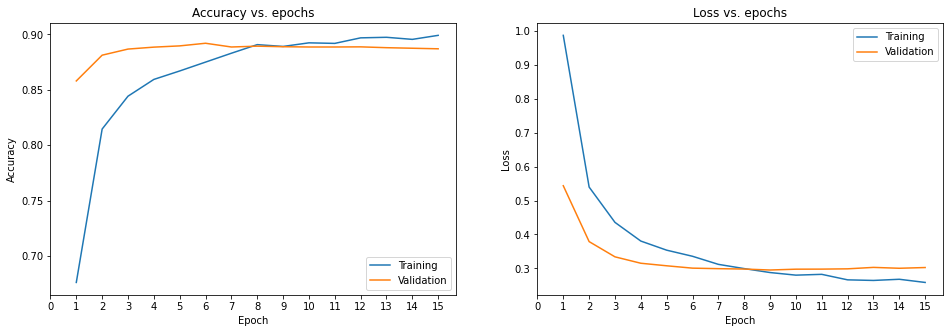

2021-07-21 08:24:32,486: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp1
----------------------------------------evaluate----------------------------------------


2021-07-21 08:24:42,681: INFO: test loss:0.3006
2021-07-21 08:24:42,681: INFO: test accuracy:0.8920
2021-07-21 08:24:42,683: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:24:42,684: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:24:42,685: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/ngram_preproess.generator
2021-07-21 08:24:42,797: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/ngram_preproess.generator
2021-07-21 08:24:42,798: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp2


----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-07-21 08:24:43,110: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/ngram_map.generator


2021-07-21 08:24:43,434: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


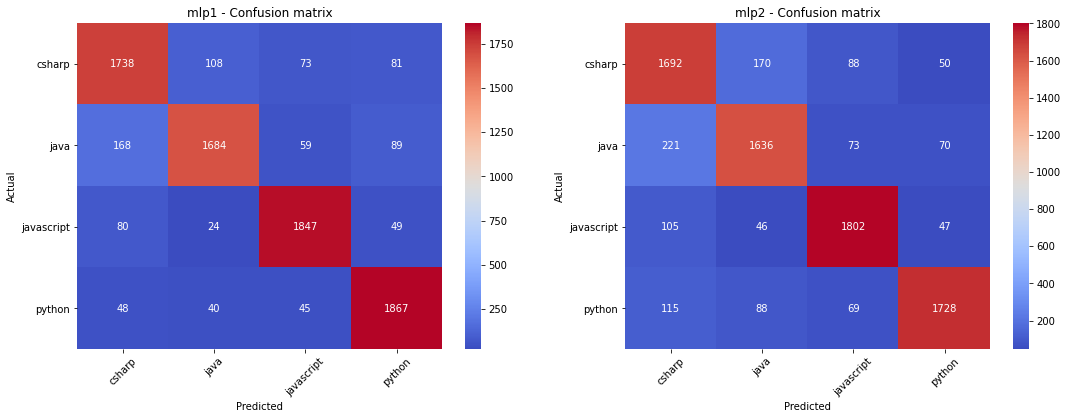

2021-07-21 08:24:52,586: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp2


----------------------------------------sample analysis----------------------------------------


2021-07-21 08:24:53,135: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/ngram_map.generator


2021-07-21 08:24:53,446: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


----------------------------------------1. java----------------------------------------
"averaging letter grades to calculate gpa average for blank i have to input a letter grade, example a+,b-,c, etc., and i need blank to calculate the numerical average based on the grades entered. my teacher wants us to create the program so that the user has to input 5 letter grades, and then blank calculates the numerical average. please help. i'm so lost."



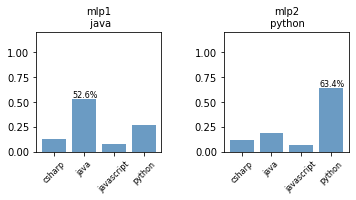

----------------------------------------2. python----------------------------------------
"how would i call variables from one method to another method? how can i put the variables of ""ab, bc, cd, &amp; da"" of dsada() method into the 123132 method without copying and pasting? (the *dsada** method also has a method from distance inside it too)"



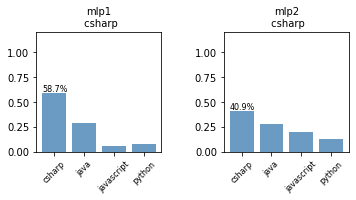

----------------------------------------3. java----------------------------------------
"how to set priorities for multiple threads in blank how does one set different priorities for different threads on blank?.let us assume i have three threads a,b,c..and i want a to be of high priority...how do i set the priority value in each case? can i get a sample code for that?"



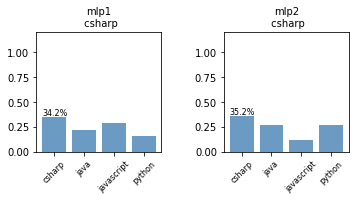

----------------------------------------4. java----------------------------------------
"handling encoded/decoded inputs i'm using ..urldecoder.decode(data,""utf-8"")...to decode my string, e.g. 100%20natural => 100 natural..now the fun part, data can be already encoded, or decoded. so if i have something likes ""100% natural"", it will result in exception...at the moment i'm laying on exception to get the correct value, so in case exception happened, i returned the original value...how i can handle this situation better without laying on the exception to detect if my data needs to be decoded or not? since throwing exception is also expensive...thank you."



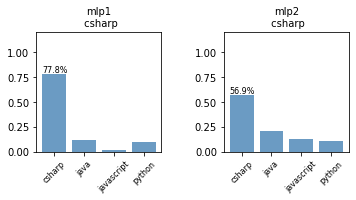

----------------------------------------5. csharp----------------------------------------
"without private constructor we can access static member from one to other class? use of private constructor :. it cant able to create instance,. it cant be inherit,. it contain only static data members..without  private constructor also i can able to access class with its static declaration and static data member when assign value like the below example ..class test.{        .    public static int x = 12;.    public static int method().    {.        return 13;.    }.}.class program.{.    int resut1 = test.x;.    int resut2 = test.method();.    static void main(string[] args).    {.    }.}...so i have doubts as below. why should go to private constructor. what is the use of private constructor block. is we cant do anything inside of private constructor block. when it execute please explain clearly..thanks in advance"



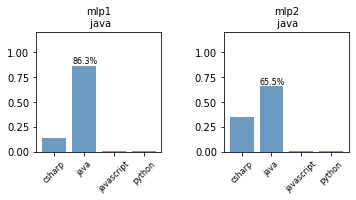

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,mlp1,2561284,19.4,0.1675,0.3006,0.9570,0.8920,0.9972,0.9844
2,mlp2,2561284,25.1,0.2033,0.4538,0.9843,0.8572,0.9992,0.9743


In [29]:
helper = qtf.classification.Classification(params, datasets=ngram_datasets1, model_results=model_results)
model = qtf.classification.models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True)

#### mlp2

2021-07-21 08:24:59,712: INFO: model_params.mlp2.dropout=0.6
2021-07-21 08:24:59,713: INFO: model_params.mlp2.layer_count=1
2021-07-21 08:24:59,714: INFO: model_params.mlp2.units=256
2021-07-21 08:24:59,733: INFO: output_bias=[-1.38629436 -1.38629436 -1.38629436 -1.38629436]
2021-07-21 08:24:59,739: INFO: learning_rate=0.001
2021-07-21 08:24:59,740: INFO: model_params.mlp2.clip_value=None
2021-07-21 08:24:59,745: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp2
2021-07-21 08:24:59,747: INFO: model_params.mlp2.epochs=15
2021-07-21 08:24:59,748: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp2, monitor=val_accuracy)
2021-07-21 08:24:59,749: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 08:24:59,749: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794

TensorSpec(shape=(32, 10000), dtype=tf.float32, name=None)
Model: "mlp2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 10000)             0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               2560256   
_________________________________________________________________
dropout_7 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 1028      
Total params: 2,561,284
Trainable params: 2,561,284
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
250/250 [==============================] - 1s 4m

2021-07-21 08:25:01,621: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp2/assets


Epoch 2/15
250/250 [==============================] - 1s 3ms/step - loss: 0.8315 - accuracy: 0.7395 - val_loss: 0.5995 - val_accuracy: 0.8190
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp2/assets


2021-07-21 08:25:03,136: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp2/assets


Epoch 3/15
250/250 [==============================] - 1s 3ms/step - loss: 0.6719 - accuracy: 0.7704 - val_loss: 0.5327 - val_accuracy: 0.8413
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp2/assets


2021-07-21 08:25:04,615: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp2/assets


Epoch 4/15
250/250 [==============================] - 1s 3ms/step - loss: 0.6307 - accuracy: 0.7952 - val_loss: 0.5277 - val_accuracy: 0.8259
Epoch 5/15
250/250 [==============================] - 1s 3ms/step - loss: 0.5661 - accuracy: 0.8126 - val_loss: 0.5133 - val_accuracy: 0.8536
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp2/assets


2021-07-21 08:25:06,985: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp2/assets


Epoch 6/15
250/250 [==============================] - 1s 3ms/step - loss: 0.5268 - accuracy: 0.8219 - val_loss: 0.5014 - val_accuracy: 0.8456
Epoch 7/15
250/250 [==============================] - 1s 3ms/step - loss: 0.5461 - accuracy: 0.8155 - val_loss: 0.4783 - val_accuracy: 0.8506
Epoch 8/15
250/250 [==============================] - 1s 3ms/step - loss: 0.5074 - accuracy: 0.8411 - val_loss: 0.4714 - val_accuracy: 0.8535
Epoch 9/15
250/250 [==============================] - 1s 3ms/step - loss: 0.5314 - accuracy: 0.8289 - val_loss: 0.4500 - val_accuracy: 0.8509
Epoch 10/15
250/250 [==============================] - 1s 3ms/step - loss: 0.4837 - accuracy: 0.8444 - val_loss: 0.4817 - val_accuracy: 0.8485
Epoch 11/15
250/250 [==============================] - 1s 3ms/step - loss: 0.4388 - accuracy: 0.8525 - val_loss: 0.4815 - val_accuracy: 0.8363
Epoch 12/15
250/250 [==============================] - 1s 3ms/step - loss: 0.4429 - accuracy: 0.8521 - val_loss: 0.4528 - val_accuracy: 0.8482
Epo

2021-07-21 08:25:14,447: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp2/assets


Epoch 14/15
250/250 [==============================] - 1s 3ms/step - loss: 0.4092 - accuracy: 0.8714 - val_loss: 0.4293 - val_accuracy: 0.8589
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp2/assets


2021-07-21 08:25:16,115: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp2/assets


Epoch 15/15
250/250 [==============================] - 1s 3ms/step - loss: 0.3993 - accuracy: 0.8655 - val_loss: 0.4615 - val_accuracy: 0.8522


2021-07-21 08:25:17,532: INFO: finish training [elapsed time: 17.78 seconds]


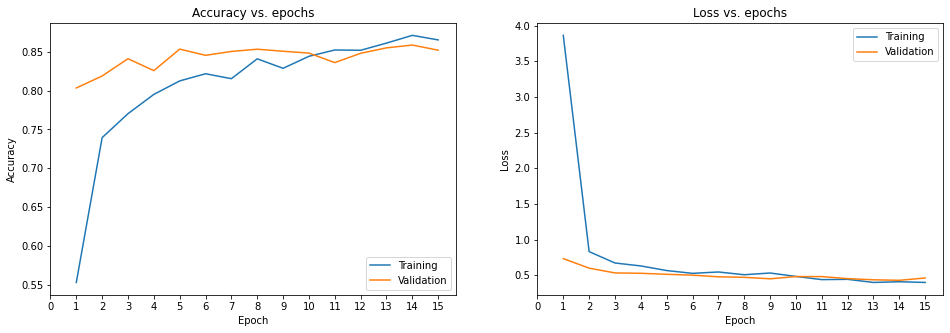

2021-07-21 08:25:18,003: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp2


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp2
----------------------------------------evaluate----------------------------------------


2021-07-21 08:25:28,170: INFO: test loss:0.4293
2021-07-21 08:25:28,171: INFO: test accuracy:0.8589
2021-07-21 08:25:28,172: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:25:28,174: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:25:28,174: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/ngram_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 08:25:28,179: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-21 08:25:28,217: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/ngram_map.layer/assets


2021-07-21 08:25:28,762: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/ngram_map.layer/assets
2021-07-21 08:25:28,782: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/ngram_map.generator
2021-07-21 08:25:28,782: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp1


----------------------------------------confusion matrix----------------------------------------


2021-07-21 08:25:29,091: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/ngram_preproess.generator


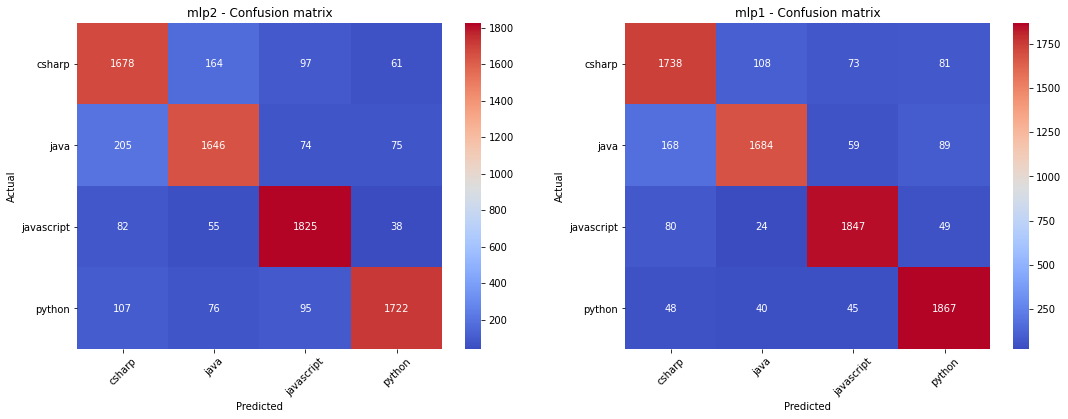

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,mlp1,2561284,19.4,0.1675,0.3006,0.9570,0.8920,0.9972,0.9844
2,mlp2,2561284,17.3,0.1404,0.4293,0.9875,0.8589,0.9997,0.9761


In [30]:
helper = qtf.classification.Classification(params, datasets=ngram_datasets2, model_results=model_results)
model = qtf.classification.models.mlp1(helper, name='mlp2')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### Embedding

#### embedding

2021-07-21 08:25:38,517: INFO: model_params.embedding.dropout=0.4
2021-07-21 08:25:38,518: INFO: model_params.embedding.embedding_dim=200
2021-07-21 08:25:38,542: INFO: output_bias=[-1.38629436 -1.38629436 -1.38629436 -1.38629436]
2021-07-21 08:25:38,549: INFO: learning_rate=0.001
2021-07-21 08:25:38,550: INFO: model_params.embedding.clip_value=None
2021-07-21 08:25:38,555: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding
2021-07-21 08:25:38,558: INFO: model_params.embedding.epochs=15
2021-07-21 08:25:38,559: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding, monitor=val_accuracy)
2021-07-21 08:25:38,559: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 08:25:38,560: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-07-21

TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)
Model: "embedding"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 500, 200)     2000000     input_8[0][0]                    
__________________________________________________________________________________________________
global_average_pooling1d_1 (Glo (None, 200)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d_1 (GlobalM (None, 200)          0           embedding_1[0][0]                
___________________________________

2021-07-21 08:25:43,402: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding/assets


Epoch 2/15
250/250 [==============================] - 4s 15ms/step - loss: 0.4192 - accuracy: 0.8809 - val_loss: 0.3595 - val_accuracy: 0.8790
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding/assets


2021-07-21 08:25:47,727: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding/assets


Epoch 3/15
250/250 [==============================] - 4s 15ms/step - loss: 0.2660 - accuracy: 0.9310 - val_loss: 0.3060 - val_accuracy: 0.8874
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding/assets


2021-07-21 08:25:52,065: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding/assets


Epoch 4/15
250/250 [==============================] - 4s 15ms/step - loss: 0.1847 - accuracy: 0.9572 - val_loss: 0.2842 - val_accuracy: 0.8924
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding/assets


2021-07-21 08:25:56,394: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding/assets


Epoch 5/15
250/250 [==============================] - 4s 15ms/step - loss: 0.1279 - accuracy: 0.9749 - val_loss: 0.2754 - val_accuracy: 0.8931
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding/assets


2021-07-21 08:26:01,045: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding/assets


Epoch 6/15
250/250 [==============================] - 4s 15ms/step - loss: 0.0877 - accuracy: 0.9846 - val_loss: 0.2730 - val_accuracy: 0.8945
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding/assets


2021-07-21 08:26:05,409: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding/assets


Epoch 7/15
250/250 [==============================] - 4s 15ms/step - loss: 0.0599 - accuracy: 0.9912 - val_loss: 0.2747 - val_accuracy: 0.8959
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding/assets


2021-07-21 08:26:09,754: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding/assets


Epoch 8/15
250/250 [==============================] - 4s 15ms/step - loss: 0.0410 - accuracy: 0.9952 - val_loss: 0.2783 - val_accuracy: 0.8942
Epoch 9/15
250/250 [==============================] - 4s 15ms/step - loss: 0.0284 - accuracy: 0.9976 - val_loss: 0.2829 - val_accuracy: 0.8935
Epoch 10/15
250/250 [==============================] - 4s 15ms/step - loss: 0.0199 - accuracy: 0.9984 - val_loss: 0.2880 - val_accuracy: 0.8941
Epoch 11/15
250/250 [==============================] - 4s 15ms/step - loss: 0.0142 - accuracy: 0.9992 - val_loss: 0.2933 - val_accuracy: 0.8950
Epoch 12/15
250/250 [==============================] - 4s 15ms/step - loss: 0.0103 - accuracy: 0.9995 - val_loss: 0.2988 - val_accuracy: 0.8936
Epoch 13/15
250/250 [==============================] - 4s 15ms/step - loss: 0.0077 - accuracy: 0.9999 - val_loss: 0.3042 - val_accuracy: 0.8931
Epoch 14/15
250/250 [==============================] - 4s 15ms/step - loss: 0.0059 - accuracy: 1.0000 - val_loss: 0.3094 - val_accuracy: 0

2021-07-21 08:26:40,393: INFO: finish training [elapsed time: 61.83 seconds]


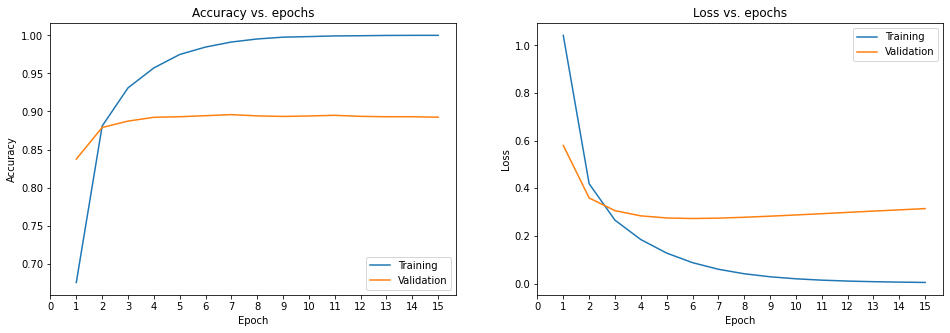

2021-07-21 08:26:40,872: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding
----------------------------------------evaluate----------------------------------------


2021-07-21 08:26:50,103: INFO: test loss:0.2747
2021-07-21 08:26:50,104: INFO: test accuracy:0.8959
2021-07-21 08:26:50,105: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:26:50,106: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:26:50,107: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 08:26:50,111: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-21 08:26:50,151: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.layer/assets


2021-07-21 08:26:50,707: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.layer/assets
2021-07-21 08:26:50,727: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator
2021-07-21 08:26:50,728: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp1


----------------------------------------confusion matrix----------------------------------------


2021-07-21 08:26:51,027: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/ngram_preproess.generator


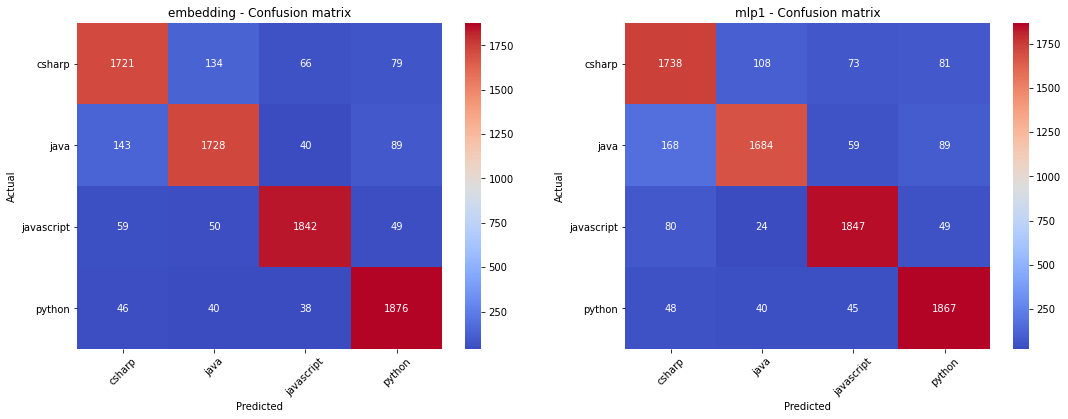

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,embedding,2001604,61.3,0.0421,0.2747,0.9959,0.8959,0.9999,0.9868
2,mlp1,2561284,19.4,0.1675,0.3006,0.9570,0.8920,0.9972,0.9844
3,mlp2,2561284,17.3,0.1404,0.4293,0.9875,0.8589,0.9997,0.9761


In [31]:
# helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets1)
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.embedding1(helper, name='embedding')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### embedding_ft

2021-07-21 08:26:59,231: INFO: model_params.embedding_ft.dropout=0.4
2021-07-21 08:26:59,231: INFO: model_params.embedding_ft.embedding_dim=200
2021-07-21 08:26:59,260: INFO: output_bias=[-1.38629436 -1.38629436 -1.38629436 -1.38629436]
2021-07-21 08:26:59,267: INFO: learning_rate=0.001
2021-07-21 08:26:59,268: INFO: model_params.embedding_ft.clip_value=None
2021-07-21 08:26:59,273: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft
2021-07-21 08:26:59,276: INFO: model_params.embedding_ft.epochs=15
2021-07-21 08:26:59,277: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft, monitor=val_accuracy)
2021-07-21 08:26:59,278: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 08:26:59,278: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patie

TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)
10000 300
Model: "embedding_ft"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 500, 300)     3000000     input_10[0][0]                   
__________________________________________________________________________________________________
global_average_pooling1d_2 (Glo (None, 300)          0           embedding_2[0][0]                
__________________________________________________________________________________________________
global_max_pooling1d_2 (GlobalM (None, 300)          0           embedding_2[0][0]                
______________________

2021-07-21 08:27:05,688: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


Epoch 2/15
250/250 [==============================] - 5s 21ms/step - loss: 0.6196 - accuracy: 0.8410 - val_loss: 0.5102 - val_accuracy: 0.8428
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


2021-07-21 08:27:11,572: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


Epoch 3/15
250/250 [==============================] - 5s 21ms/step - loss: 0.3892 - accuracy: 0.9026 - val_loss: 0.4000 - val_accuracy: 0.8608
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


2021-07-21 08:27:17,861: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


Epoch 4/15
250/250 [==============================] - 5s 21ms/step - loss: 0.2784 - accuracy: 0.9364 - val_loss: 0.3523 - val_accuracy: 0.8673
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


2021-07-21 08:27:23,733: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


Epoch 5/15
250/250 [==============================] - 5s 21ms/step - loss: 0.2089 - accuracy: 0.9564 - val_loss: 0.3270 - val_accuracy: 0.8721
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


2021-07-21 08:27:29,621: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


Epoch 6/15
250/250 [==============================] - 5s 21ms/step - loss: 0.1590 - accuracy: 0.9693 - val_loss: 0.3119 - val_accuracy: 0.8773
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


2021-07-21 08:27:35,494: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


Epoch 7/15
250/250 [==============================] - 5s 21ms/step - loss: 0.1212 - accuracy: 0.9793 - val_loss: 0.3022 - val_accuracy: 0.8824
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


2021-07-21 08:27:41,456: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


Epoch 8/15
250/250 [==============================] - 5s 22ms/step - loss: 0.0919 - accuracy: 0.9879 - val_loss: 0.2954 - val_accuracy: 0.8856
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


2021-07-21 08:27:47,503: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


Epoch 9/15
250/250 [==============================] - 5s 21ms/step - loss: 0.0693 - accuracy: 0.9920 - val_loss: 0.2910 - val_accuracy: 0.8873
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


2021-07-21 08:27:53,439: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


Epoch 10/15
250/250 [==============================] - 5s 21ms/step - loss: 0.0521 - accuracy: 0.9948 - val_loss: 0.2888 - val_accuracy: 0.8894
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


2021-07-21 08:27:59,386: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


Epoch 11/15
250/250 [==============================] - 5s 22ms/step - loss: 0.0391 - accuracy: 0.9975 - val_loss: 0.2889 - val_accuracy: 0.8899
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


2021-07-21 08:28:05,493: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft/assets


Epoch 12/15
250/250 [==============================] - 5s 21ms/step - loss: 0.0295 - accuracy: 0.9986 - val_loss: 0.2904 - val_accuracy: 0.8882
Epoch 13/15
250/250 [==============================] - 5s 21ms/step - loss: 0.0224 - accuracy: 0.9994 - val_loss: 0.2920 - val_accuracy: 0.8895
Epoch 14/15
250/250 [==============================] - 5s 22ms/step - loss: 0.0172 - accuracy: 0.9995 - val_loss: 0.2937 - val_accuracy: 0.8895
Epoch 15/15
250/250 [==============================] - 5s 22ms/step - loss: 0.0133 - accuracy: 0.9996 - val_loss: 0.2956 - val_accuracy: 0.8898


2021-07-21 08:28:27,560: INFO: finish training [elapsed time: 88.28 seconds]


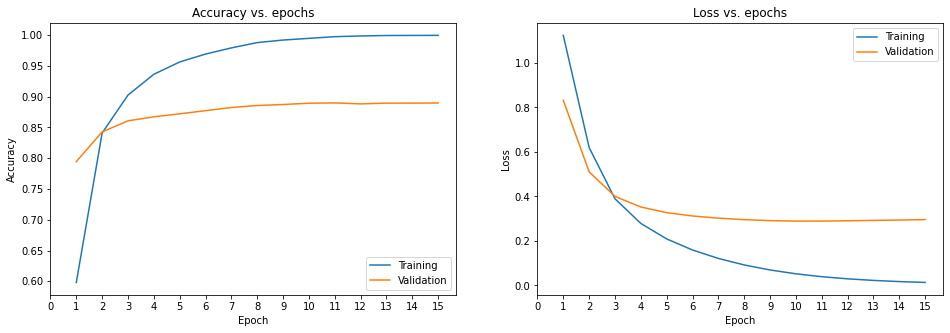

2021-07-21 08:28:28,029: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft
----------------------------------------evaluate----------------------------------------


2021-07-21 08:28:38,274: INFO: test loss:0.2889
2021-07-21 08:28:38,275: INFO: test accuracy:0.8899
2021-07-21 08:28:38,276: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:28:38,278: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:28:38,278: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 08:28:38,283: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-21 08:28:38,327: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.layer/assets


2021-07-21 08:28:38,943: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.layer/assets
2021-07-21 08:28:38,968: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator
2021-07-21 08:28:38,969: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding


----------------------------------------confusion matrix----------------------------------------


2021-07-21 08:28:39,268: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


2021-07-21 08:28:39,631: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


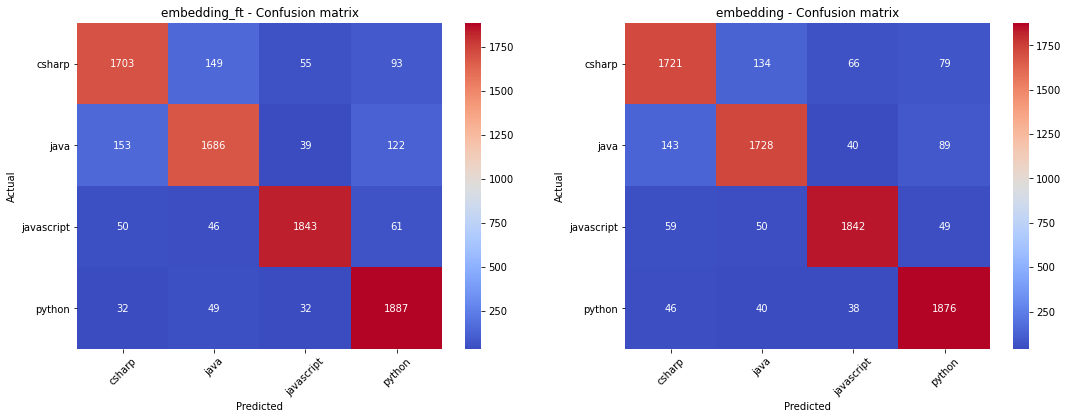

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,embedding,2001604,61.3,0.0421,0.2747,0.9959,0.8959,0.9999,0.9868
2,mlp1,2561284,19.4,0.1675,0.3006,0.9570,0.8920,0.9972,0.9844
3,embedding_ft,3002404,87.8,0.0309,0.2889,0.9989,0.8899,1.0000,0.9856
4,mlp2,2561284,17.3,0.1404,0.4293,0.9875,0.8589,0.9997,0.9761


In [32]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.embedding1(helper, name='embedding_ft',
                                             embedding_matrix=embedding_matrix_fasttext,
                                             is_embedding_trainable=True)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### sepCNN

#### sepcnn

2021-07-21 08:28:47,927: INFO: model_params.sepcnn.dropout=0.4
2021-07-21 08:28:47,994: INFO: output_bias=[-1.38629436 -1.38629436 -1.38629436 -1.38629436]
2021-07-21 08:28:48,000: INFO: learning_rate=0.001
2021-07-21 08:28:48,000: INFO: model_params.sepcnn.clip_value=None
2021-07-21 08:28:48,005: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn
2021-07-21 08:28:48,009: INFO: model_params.sepcnn.epochs=10
2021-07-21 08:28:48,009: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn, monitor=val_accuracy)
2021-07-21 08:28:48,010: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 08:28:48,010: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-07-21 08:28:48,011: INFO: use LearningRateScheduler()
2021-07-21 08:28:48,012: INFO: start t

TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)
Model: "sepcnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 200)          2000200   
_________________________________________________________________
dropout_8 (Dropout)          (None, 500, 200)          0         
_________________________________________________________________
separable_conv1d (SeparableC (None, 500, 128)          26328     
_________________________________________________________________
separable_conv1d_1 (Separabl (None, 500, 128)          16896     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 166, 128)          0         
_________________________________________________________________
global_average_pooling1d_3 ( (None, 128)               0         
_________________________________________________________________
dropo

2021-07-21 08:28:56,428: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn/assets


Epoch 2/10
250/250 [==============================] - 6s 23ms/step - loss: 0.7937 - accuracy: 0.6805 - val_loss: 0.5149 - val_accuracy: 0.8084
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn/assets


2021-07-21 08:29:03,285: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn/assets


Epoch 3/10
250/250 [==============================] - 6s 23ms/step - loss: 0.4162 - accuracy: 0.8485 - val_loss: 0.4287 - val_accuracy: 0.8451
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn/assets


2021-07-21 08:29:10,226: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn/assets


Epoch 4/10
250/250 [==============================] - 6s 24ms/step - loss: 0.2922 - accuracy: 0.8955 - val_loss: 0.4226 - val_accuracy: 0.8537
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn/assets


2021-07-21 08:29:17,530: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn/assets


Epoch 5/10
250/250 [==============================] - 6s 25ms/step - loss: 0.2160 - accuracy: 0.9245 - val_loss: 0.4629 - val_accuracy: 0.8541
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn/assets


2021-07-21 08:29:24,845: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn/assets


Epoch 6/10
250/250 [==============================] - 6s 25ms/step - loss: 0.1640 - accuracy: 0.9444 - val_loss: 0.5009 - val_accuracy: 0.8547
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn/assets


2021-07-21 08:29:32,345: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn/assets


Epoch 7/10
250/250 [==============================] - 6s 25ms/step - loss: 0.1299 - accuracy: 0.9590 - val_loss: 0.5496 - val_accuracy: 0.8543
Epoch 8/10
250/250 [==============================] - 6s 25ms/step - loss: 0.1119 - accuracy: 0.9659 - val_loss: 0.6218 - val_accuracy: 0.8501
Epoch 9/10
250/250 [==============================] - 6s 24ms/step - loss: 0.0880 - accuracy: 0.9734 - val_loss: 0.6841 - val_accuracy: 0.8471
Epoch 10/10
250/250 [==============================] - 6s 24ms/step - loss: 0.0808 - accuracy: 0.9762 - val_loss: 0.7368 - val_accuracy: 0.8455


2021-07-21 08:29:57,428: INFO: finish training [elapsed time: 69.42 seconds]


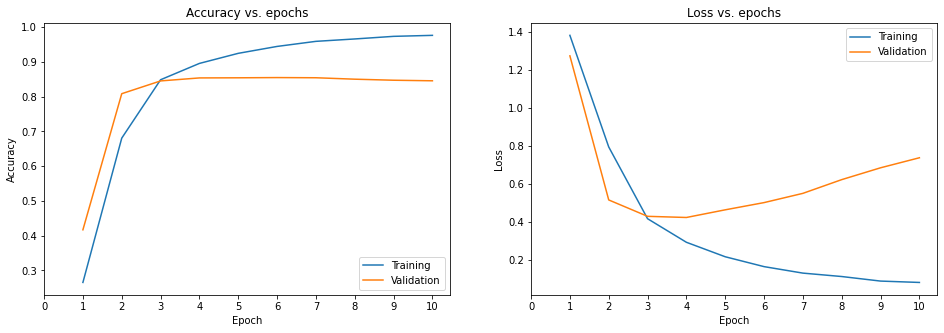

2021-07-21 08:29:57,834: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn
----------------------------------------evaluate----------------------------------------


2021-07-21 08:30:08,161: INFO: test loss:0.5009
2021-07-21 08:30:08,162: INFO: test accuracy:0.8547
2021-07-21 08:30:08,164: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:30:08,165: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:30:08,166: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 08:30:08,170: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-21 08:30:08,211: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.layer/assets


2021-07-21 08:30:08,789: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.layer/assets
2021-07-21 08:30:08,811: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator
2021-07-21 08:30:08,812: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding


----------------------------------------confusion matrix----------------------------------------


2021-07-21 08:30:09,086: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


2021-07-21 08:30:09,684: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


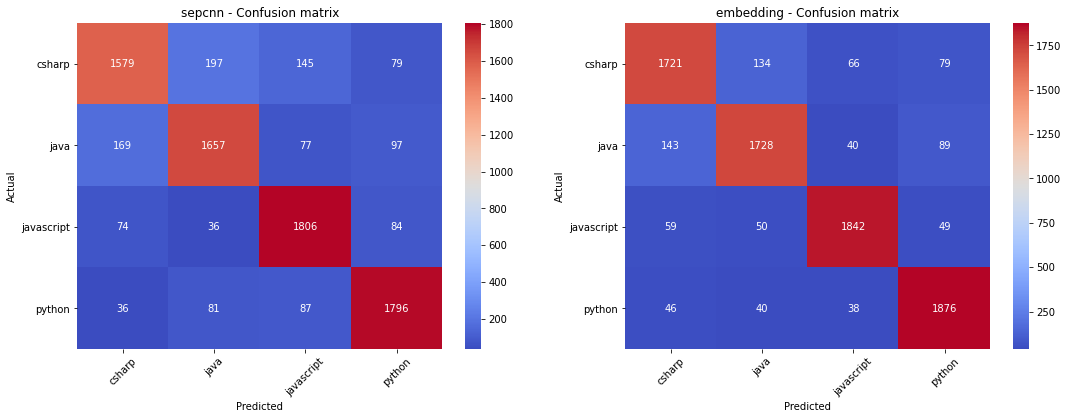

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,embedding,2001604,61.3,0.0421,0.2747,0.9959,0.8959,0.9999,0.9868
2,mlp1,2561284,19.4,0.1675,0.3006,0.9570,0.8920,0.9972,0.9844
3,embedding_ft,3002404,87.8,0.0309,0.2889,0.9989,0.8899,1.0000,0.9856
4,mlp2,2561284,17.3,0.1404,0.4293,0.9875,0.8589,0.9997,0.9761
5,sepcnn,2043940,68.9,0.1012,0.5009,0.9691,0.8547,0.9984,0.9736


In [33]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.sepcnn1(helper, name='sepcnn', blocks=1)
# when bolcks=2, the model can't converg
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### sepcnn_ft

2021-07-21 08:30:17,992: INFO: model_params.sepcnn_ft.dropout=0.4
2021-07-21 08:30:18,061: INFO: output_bias=[-1.38629436 -1.38629436 -1.38629436 -1.38629436]
2021-07-21 08:30:18,067: INFO: learning_rate=0.001
2021-07-21 08:30:18,068: INFO: model_params.sepcnn_ft.clip_value=None
2021-07-21 08:30:18,073: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn_ft
2021-07-21 08:30:18,076: INFO: model_params.sepcnn_ft.epochs=10
2021-07-21 08:30:18,077: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn_ft, monitor=val_accuracy)
2021-07-21 08:30:18,077: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 08:30:18,078: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-07-21 08:30:18,078: INFO: use LearningRateScheduler()
2021-07-21 08:30:18,079

TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)
Model: "sepcnn_ft"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 300)          3000000   
_________________________________________________________________
dropout_10 (Dropout)         (None, 500, 300)          0         
_________________________________________________________________
separable_conv1d_2 (Separabl (None, 500, 128)          39428     
_________________________________________________________________
separable_conv1d_3 (Separabl (None, 500, 128)          16896     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 166, 128)          0         
_________________________________________________________________
global_average_pooling1d_4 ( (None, 128)               0         
_________________________________________________________________
dr

2021-07-21 08:30:27,883: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn_ft/assets


Epoch 2/10
250/250 [==============================] - 10s 39ms/step - loss: 0.5499 - accuracy: 0.7991 - val_loss: 0.4473 - val_accuracy: 0.8379
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn_ft/assets


2021-07-21 08:30:39,173: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn_ft/assets


Epoch 3/10
250/250 [==============================] - 10s 39ms/step - loss: 0.3790 - accuracy: 0.8676 - val_loss: 0.4016 - val_accuracy: 0.8586
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn_ft/assets


2021-07-21 08:30:50,448: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn_ft/assets


Epoch 4/10
250/250 [==============================] - 10s 38ms/step - loss: 0.2834 - accuracy: 0.8992 - val_loss: 0.4005 - val_accuracy: 0.8658
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn_ft/assets


2021-07-21 08:31:01,580: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn_ft/assets


Epoch 5/10
250/250 [==============================] - 10s 39ms/step - loss: 0.2220 - accuracy: 0.9234 - val_loss: 0.4238 - val_accuracy: 0.8652
Epoch 6/10
250/250 [==============================] - 10s 40ms/step - loss: 0.1760 - accuracy: 0.9375 - val_loss: 0.4667 - val_accuracy: 0.8639
Epoch 7/10
250/250 [==============================] - 10s 41ms/step - loss: 0.1513 - accuracy: 0.9498 - val_loss: 0.4741 - val_accuracy: 0.8670
INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn_ft/assets


2021-07-21 08:31:33,455: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn_ft/assets


Epoch 8/10
250/250 [==============================] - 10s 40ms/step - loss: 0.1234 - accuracy: 0.9579 - val_loss: 0.5199 - val_accuracy: 0.8635
Epoch 9/10
250/250 [==============================] - 10s 40ms/step - loss: 0.1061 - accuracy: 0.9663 - val_loss: 0.5558 - val_accuracy: 0.8627
Epoch 10/10
250/250 [==============================] - 7s 30ms/step - loss: 0.0847 - accuracy: 0.9731 - val_loss: 0.5880 - val_accuracy: 0.8645


2021-07-21 08:32:01,473: INFO: finish training [elapsed time: 103.39 seconds]


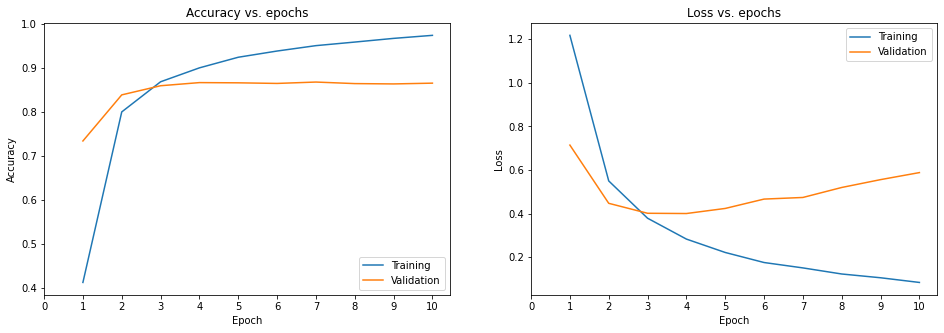

2021-07-21 08:32:01,973: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn_ft


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn_ft
----------------------------------------evaluate----------------------------------------


2021-07-21 08:32:13,828: INFO: test loss:0.4741
2021-07-21 08:32:13,829: INFO: test accuracy:0.8670
2021-07-21 08:32:13,831: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:32:13,832: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:32:13,833: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 08:32:13,837: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-21 08:32:13,878: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.layer/assets


2021-07-21 08:32:14,439: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.layer/assets
2021-07-21 08:32:14,461: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator
2021-07-21 08:32:14,462: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding


----------------------------------------confusion matrix----------------------------------------


2021-07-21 08:32:14,736: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


2021-07-21 08:32:15,061: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


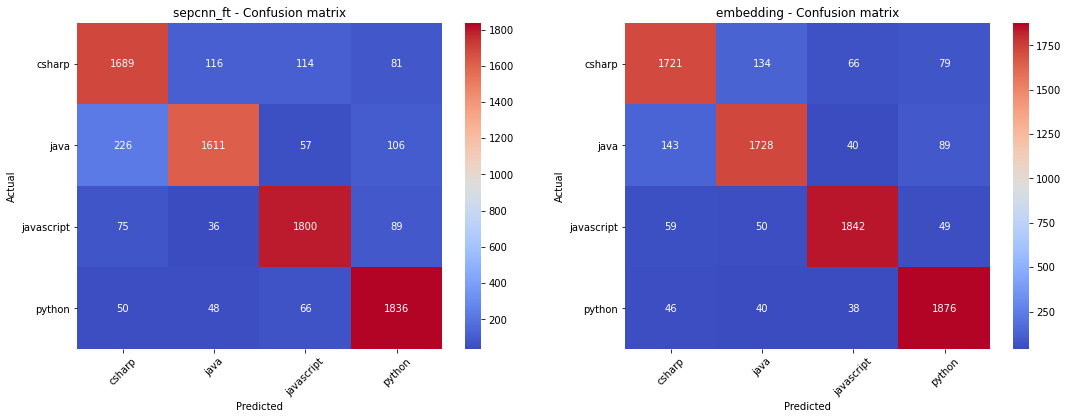

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,embedding,2001604,61.3,0.0421,0.2747,0.9959,0.8959,0.9999,0.9868
2,mlp1,2561284,19.4,0.1675,0.3006,0.9570,0.8920,0.9972,0.9844
3,embedding_ft,3002404,87.8,0.0309,0.2889,0.9989,0.8899,1.0000,0.9856
4,sepcnn_ft,3056840,102.9,0.0855,0.4741,0.9759,0.8670,0.9989,0.9764
5,mlp2,2561284,17.3,0.1404,0.4293,0.9875,0.8589,0.9997,0.9761
6,sepcnn,2043940,68.9,0.1012,0.5009,0.9691,0.8547,0.9984,0.9736


In [34]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.sepcnn1(helper, name='sepcnn_ft', blocks=1,
                                          embedding_matrix=embedding_matrix_fasttext,
                                          is_embedding_trainable=True)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### LSTM

#### rnn_lstm

2021-07-21 08:32:23,587: INFO: model_params.rnn_lstm.dropout=0.4
2021-07-21 08:32:23,588: INFO: model_params.rnn_lstm.units=200
2021-07-21 08:32:23,588: INFO: max_features=10000
2021-07-21 08:32:23,589: INFO: model_params.rnn_lstm.embedding_dim=200


TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)


2021-07-21 08:32:24,370: INFO: output_bias=[-1.38629436 -1.38629436 -1.38629436 -1.38629436]
2021-07-21 08:32:24,378: INFO: learning_rate=0.001
2021-07-21 08:32:24,379: INFO: model_params.rnn_lstm.clip_value=None
2021-07-21 08:32:24,384: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/rnn_lstm
2021-07-21 08:32:24,387: INFO: model_params.rnn_lstm.epochs=5
2021-07-21 08:32:24,388: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/rnn_lstm, monitor=val_accuracy)
2021-07-21 08:32:24,388: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 08:32:24,389: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-07-21 08:32:24,390: INFO: use LearningRateScheduler()
2021-07-21 08:32:24,390: INFO: start training
2021-07-21 08:32:24,391: INFO: use_class_weight=

Model: "rnn_lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 500, 200)          2000200   
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 400)          641600    
_________________________________________________________________
lstm_1 (LSTM)                (None, 200)               480800    
_________________________________________________________________
dropout_12 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 4)                 804       
Total params: 3,123,404
Trainable params: 3,123,404
Non-trainable params: 0
________________________________________________

2021-07-21 08:33:17,398: WARNING: Found untraced functions such as lstm_cell_3_layer_call_fn, lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/rnn_lstm/assets


2021-07-21 08:33:20,169: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/rnn_lstm/assets


Epoch 2/5
250/250 [==============================] - 31s 123ms/step - loss: 1.4223 - accuracy: 0.2548 - val_loss: 1.3882 - val_accuracy: 0.2501
Epoch 3/5
250/250 [==============================] - 33s 131ms/step - loss: 1.3898 - accuracy: 0.2461 - val_loss: 1.3872 - val_accuracy: 0.2508
Epoch 4/5
250/250 [==============================] - 33s 131ms/step - loss: 1.3837 - accuracy: 0.2537 - val_loss: 1.3871 - val_accuracy: 0.2529
Epoch 5/5
250/250 [==============================] - 32s 128ms/step - loss: 1.3769 - accuracy: 0.2607 - val_loss: 1.3877 - val_accuracy: 0.2542


2021-07-21 08:35:42,452: WARNING: Found untraced functions such as lstm_cell_3_layer_call_fn, lstm_cell_3_layer_call_and_return_conditional_losses, lstm_cell_1_layer_call_fn, lstm_cell_1_layer_call_and_return_conditional_losses, lstm_cell_2_layer_call_fn while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/rnn_lstm/assets


2021-07-21 08:35:44,564: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/rnn_lstm/assets
2021-07-21 08:35:45,517: INFO: finish training [elapsed time: 201.13 seconds]


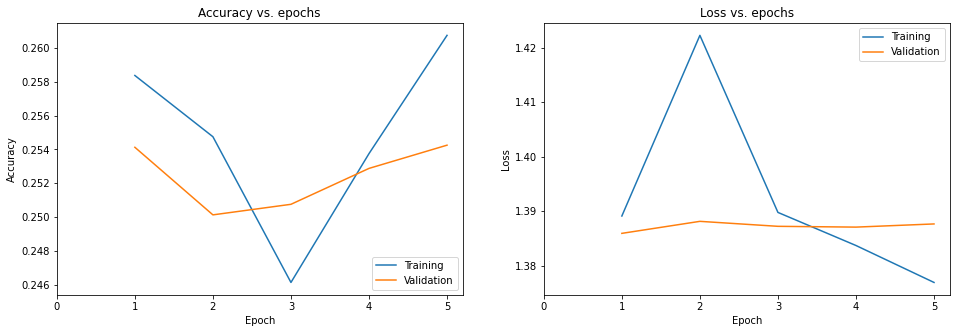

2021-07-21 08:35:45,978: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/rnn_lstm


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/rnn_lstm
----------------------------------------evaluate----------------------------------------


2021-07-21 08:36:29,491: INFO: test loss:1.3877
2021-07-21 08:36:29,493: INFO: test accuracy:0.2542
2021-07-21 08:36:29,494: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:36:29,495: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:36:29,496: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 08:36:29,500: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-21 08:36:29,539: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.layer/assets


2021-07-21 08:36:30,074: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.layer/assets
2021-07-21 08:36:30,095: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator
2021-07-21 08:36:30,096: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding


----------------------------------------confusion matrix----------------------------------------


2021-07-21 08:36:30,358: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


2021-07-21 08:36:30,671: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


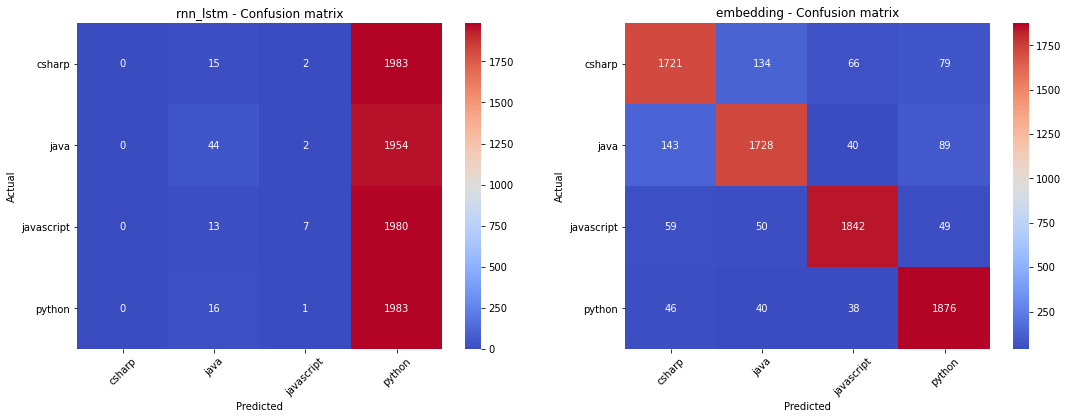

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,embedding,2001604,61.3,0.0421,0.2747,0.9959,0.8959,0.9999,0.9868
2,mlp1,2561284,19.4,0.1675,0.3006,0.9570,0.8920,0.9972,0.9844
3,embedding_ft,3002404,87.8,0.0309,0.2889,0.9989,0.8899,1.0000,0.9856
4,sepcnn_ft,3056840,102.9,0.0855,0.4741,0.9759,0.8670,0.9989,0.9764
5,mlp2,2561284,17.3,0.1404,0.4293,0.9875,0.8589,0.9997,0.9761
6,sepcnn,2043940,68.9,0.1012,0.5009,0.9691,0.8547,0.9984,0.9736
7,rnn_lstm,3123404,200.6,1.3743,1.3877,0.2625,0.2542,0.5172,0.5056


In [35]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.lstm1(helper, name='rnn_lstm')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### rnn_lstm_ft

2021-07-21 08:36:42,884: INFO: model_params.rnn_lstm_ft.dropout=0.4
2021-07-21 08:36:42,885: INFO: model_params.rnn_lstm_ft.units=200
2021-07-21 08:36:42,886: INFO: max_features=10000
2021-07-21 08:36:42,886: INFO: model_params.rnn_lstm_ft.embedding_dim=200


TensorSpec(shape=(32, 500), dtype=tf.int64, name=None)
10000 300
<class 'tensorflow.python.keras.engine.keras_tensor.KerasTensor'> 200


2021-07-21 08:36:44,015: INFO: output_bias=[-1.38629436 -1.38629436 -1.38629436 -1.38629436]
2021-07-21 08:36:44,023: INFO: learning_rate=0.001
2021-07-21 08:36:44,023: INFO: model_params.rnn_lstm_ft.clip_value=None
2021-07-21 08:36:44,029: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/rnn_lstm_ft
2021-07-21 08:36:44,032: INFO: model_params.rnn_lstm_ft.epochs=5
2021-07-21 08:36:44,032: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/rnn_lstm_ft, monitor=val_accuracy)
2021-07-21 08:36:44,033: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 08:36:44,033: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-07-21 08:36:44,034: INFO: use LearningRateScheduler()
2021-07-21 08:36:44,035: INFO: start training
2021-07-21 08:36:44,035: INFO: use_c

Model: "rnn_lstm_ft"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 500)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 500, 300)          3000000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 500, 400)          801600    
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)               480800    
_________________________________________________________________
dropout_13 (Dropout)         (None, 200)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 4)                 804       
Total params: 4,283,204
Trainable params: 4,283,204
Non-trainable params: 0
_____________________________________________

2021-07-21 08:37:37,048: WARNING: Found untraced functions such as lstm_cell_11_layer_call_fn, lstm_cell_11_layer_call_and_return_conditional_losses, lstm_cell_9_layer_call_fn, lstm_cell_9_layer_call_and_return_conditional_losses, lstm_cell_10_layer_call_fn while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/rnn_lstm_ft/assets


2021-07-21 08:37:39,198: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/rnn_lstm_ft/assets


Epoch 2/5
250/250 [==============================] - 36s 142ms/step - loss: 1.3853 - accuracy: 0.2621 - val_loss: 1.3835 - val_accuracy: 0.2559


2021-07-21 08:38:29,658: WARNING: Found untraced functions such as lstm_cell_11_layer_call_fn, lstm_cell_11_layer_call_and_return_conditional_losses, lstm_cell_9_layer_call_fn, lstm_cell_9_layer_call_and_return_conditional_losses, lstm_cell_10_layer_call_fn while saving (showing 5 of 15). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/rnn_lstm_ft/assets


2021-07-21 08:38:31,783: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/rnn_lstm_ft/assets


Epoch 3/5
250/250 [==============================] - 35s 141ms/step - loss: 1.3808 - accuracy: 0.2661 - val_loss: 1.3835 - val_accuracy: 0.2559
Epoch 4/5
250/250 [==============================] - 36s 142ms/step - loss: 1.3709 - accuracy: 0.2619 - val_loss: 1.4407 - val_accuracy: 0.2537
Epoch 5/5
250/250 [==============================] - 35s 142ms/step - loss: 1.3914 - accuracy: 0.2649 - val_loss: 1.3876 - val_accuracy: 0.2548


2021-07-21 08:40:19,143: INFO: finish training [elapsed time: 215.11 seconds]


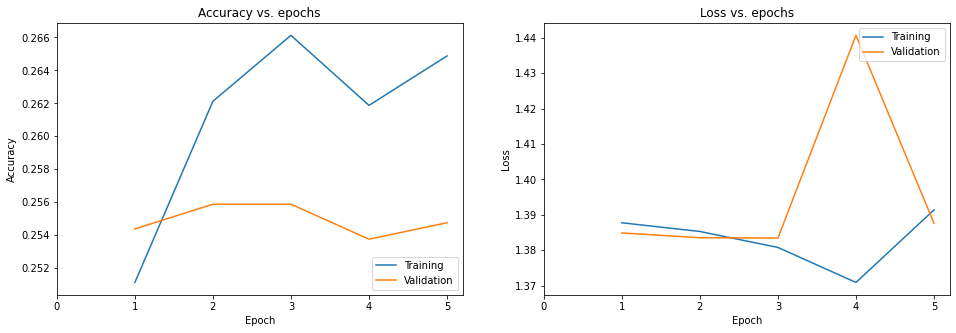

2021-07-21 08:40:20,454: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/rnn_lstm_ft


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/rnn_lstm_ft
----------------------------------------evaluate----------------------------------------


2021-07-21 08:41:07,422: INFO: test loss:1.3835
2021-07-21 08:41:07,423: INFO: test accuracy:0.2559
2021-07-21 08:41:07,424: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:41:07,426: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:41:07,426: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 08:41:07,430: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-21 08:41:07,470: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.layer/assets


2021-07-21 08:41:08,009: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.layer/assets
2021-07-21 08:41:08,029: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator
2021-07-21 08:41:08,030: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding


----------------------------------------confusion matrix----------------------------------------


2021-07-21 08:41:08,289: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


2021-07-21 08:41:08,604: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


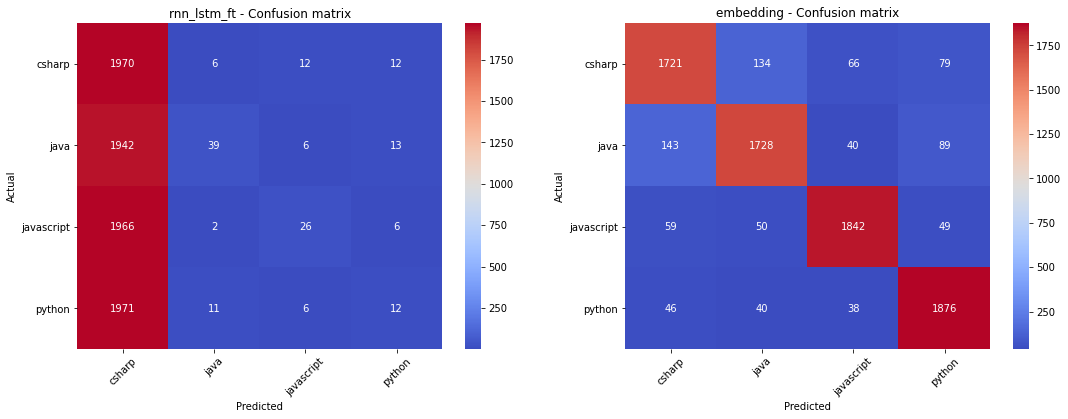

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,embedding,2001604,61.3,0.0421,0.2747,0.9959,0.8959,0.9999,0.9868
2,mlp1,2561284,19.4,0.1675,0.3006,0.9570,0.8920,0.9972,0.9844
3,embedding_ft,3002404,87.8,0.0309,0.2889,0.9989,0.8899,1.0000,0.9856
4,sepcnn_ft,3056840,102.9,0.0855,0.4741,0.9759,0.8670,0.9989,0.9764
5,mlp2,2561284,17.3,0.1404,0.4293,0.9875,0.8589,0.9997,0.9761
6,sepcnn,2043940,68.9,0.1012,0.5009,0.9691,0.8547,0.9984,0.9736
7,rnn_lstm_ft,4283204,214.6,1.3706,1.3835,0.2668,0.2559,0.5215,0.5053
8,rnn_lstm,3123404,200.6,1.3743,1.3877,0.2625,0.2542,0.5172,0.5056


In [36]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.lstm1(helper, name='rnn_lstm_ft',
                                        embedding_matrix=embedding_matrix_fasttext,
                                        is_embedding_trainable=True,
                 mask_zero=False)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

### Pooled GRU 

#### pg_default

2021-07-21 08:41:21,622: INFO: model_params.pg_default.dropout=0.4
2021-07-21 08:41:21,623: INFO: model_params.pg_default.units=80
2021-07-21 08:41:21,623: INFO: max_features=10000
2021-07-21 08:41:21,624: INFO: model_params.pg_default.embedding_dim=300
2021-07-21 08:41:22,059: INFO: output_bias=[-1.38629436 -1.38629436 -1.38629436 -1.38629436]
2021-07-21 08:41:22,067: INFO: model_params.pg_default.learning_rate=0.0005
2021-07-21 08:41:22,067: INFO: model_params.pg_default.clip_value=None
2021-07-21 08:41:22,073: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_default
2021-07-21 08:41:22,076: INFO: model_params.pg_default.epochs=20
2021-07-21 08:41:22,076: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_default, monitor=val_accuracy)
2021-07-21 08:41:22,077: INFO: use EarlyStopping(monitor=val_

Model: "pg_default"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_7 (Embedding)         (None, 500, 300)     3000000     input_18[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 500, 300)     0           embedding_7[0][0]                
__________________________________________________________________________________________________
bidirectional_2 (Bidirectional) (None, 500, 160)     183360      spatial_dropout1d[0][0]          
_________________________________________________________________________________________

2021-07-21 08:41:49,297: WARNING: Found untraced functions such as gru_cell_1_layer_call_fn, gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_2_layer_call_fn, gru_cell_2_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_default/assets


2021-07-21 08:41:50,779: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_default/assets


Epoch 2/20
Epoch 00002: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 15s 59ms/step - loss: 0.3501 - accuracy: 0.8719 - val_loss: 0.3700 - val_accuracy: 0.8584


2021-07-21 08:42:15,651: WARNING: Found untraced functions such as gru_cell_1_layer_call_fn, gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_2_layer_call_fn, gru_cell_2_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_default/assets


2021-07-21 08:42:17,345: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_default/assets


Epoch 3/20
Epoch 00003: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 16s 63ms/step - loss: 0.2055 - accuracy: 0.9293 - val_loss: 0.3792 - val_accuracy: 0.8593


2021-07-21 08:42:42,462: WARNING: Found untraced functions such as gru_cell_1_layer_call_fn, gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_2_layer_call_fn, gru_cell_2_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_default/assets


2021-07-21 08:42:43,956: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_default/assets


Epoch 4/20
Epoch 00004: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 15s 58ms/step - loss: 0.1328 - accuracy: 0.9615 - val_loss: 0.3757 - val_accuracy: 0.8644


2021-07-21 08:43:08,918: WARNING: Found untraced functions such as gru_cell_1_layer_call_fn, gru_cell_1_layer_call_and_return_conditional_losses, gru_cell_2_layer_call_fn, gru_cell_2_layer_call_and_return_conditional_losses, gru_cell_1_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_default/assets


2021-07-21 08:43:10,423: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_default/assets


Epoch 5/20
Epoch 00005: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 15s 58ms/step - loss: 0.0813 - accuracy: 0.9779 - val_loss: 0.4344 - val_accuracy: 0.8583
Epoch 6/20
Epoch 00006: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 14s 58ms/step - loss: 0.0444 - accuracy: 0.9894 - val_loss: 0.4916 - val_accuracy: 0.8562
Epoch 7/20
Epoch 00007: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 14s 58ms/step - loss: 0.0298 - accuracy: 0.9931 - val_loss: 0.5198 - val_accuracy: 0.8569
Epoch 8/20
Epoch 00008: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 15s 58ms/step - loss: 0.0169 - accuracy: 0.9971 - val_loss: 0.6122 - val_accuracy: 0.8524
Epoch 9/20
Epoch 00009: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 15s 58ms/step - loss: 0.0144 - accuracy: 0.9973 - val_loss: 

2021-07-21 08:47:04,520: INFO: finish training [elapsed time: 342.44 seconds]


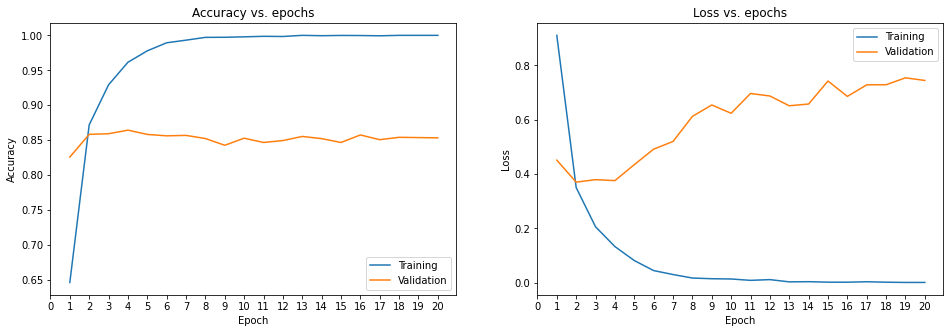

2021-07-21 08:47:05,029: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_default


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_default
----------------------------------------evaluate----------------------------------------


2021-07-21 08:47:29,270: INFO: test loss:0.3757
2021-07-21 08:47:29,271: INFO: test accuracy:0.8644
2021-07-21 08:47:29,273: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:47:29,274: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:47:29,275: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 08:47:29,279: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-21 08:47:29,322: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.layer/assets


2021-07-21 08:47:29,894: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.layer/assets
2021-07-21 08:47:29,915: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator
2021-07-21 08:47:29,916: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding


----------------------------------------confusion matrix----------------------------------------


2021-07-21 08:47:30,180: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


2021-07-21 08:47:30,495: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


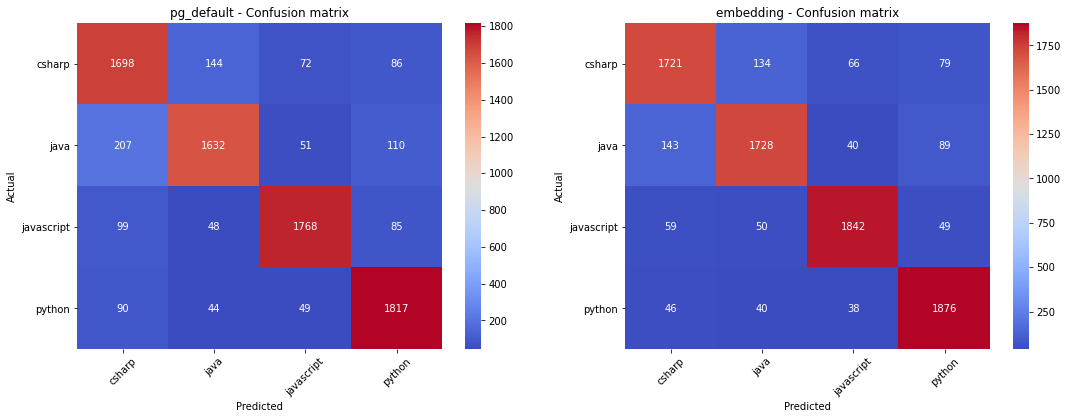

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,embedding,2001604,61.3,0.0421,0.2747,0.9959,0.8959,0.9999,0.9868
2,mlp1,2561284,19.4,0.1675,0.3006,0.9570,0.8920,0.9972,0.9844
3,embedding_ft,3002404,87.8,0.0309,0.2889,0.9989,0.8899,1.0000,0.9856
4,sepcnn_ft,3056840,102.9,0.0855,0.4741,0.9759,0.8670,0.9989,0.9764
5,pg_default,3184644,341.9,0.0765,0.3757,0.9835,0.8644,0.9992,0.9776
6,mlp2,2561284,17.3,0.1404,0.4293,0.9875,0.8589,0.9997,0.9761
7,sepcnn,2043940,68.9,0.1012,0.5009,0.9691,0.8547,0.9984,0.9736
8,rnn_lstm_ft,4283204,214.6,1.3706,1.3835,0.2668,0.2559,0.5215,0.5053
9,rnn_lstm,3123404,200.6,1.3743,1.3877,0.2625,0.2542,0.5172,0.5056


In [37]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.pooled_gru1(helper, name='pg_default')
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

#### pg_ft

2021-07-21 08:47:39,163: INFO: model_params.pg_ft.dropout=0.4
2021-07-21 08:47:39,164: INFO: model_params.pg_ft.units=80
2021-07-21 08:47:39,165: INFO: max_features=10000
2021-07-21 08:47:39,165: INFO: model_params.pg_ft.embedding_dim=300
2021-07-21 08:47:39,600: INFO: output_bias=[-1.38629436 -1.38629436 -1.38629436 -1.38629436]
2021-07-21 08:47:39,608: INFO: model_params.pg_ft.learning_rate=0.0005
2021-07-21 08:47:39,610: INFO: model_params.pg_ft.clip_value=None
2021-07-21 08:47:39,615: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_ft
2021-07-21 08:47:39,618: INFO: model_params.pg_ft.epochs=20
2021-07-21 08:47:39,619: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_ft, monitor=val_accuracy)
2021-07-21 08:47:39,619: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-07-21 08:47:

Model: "pg_ft"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           [(None, 500)]        0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 500, 300)     3000000     input_20[0][0]                   
__________________________________________________________________________________________________
spatial_dropout1d_1 (SpatialDro (None, 500, 300)     0           embedding_8[0][0]                
__________________________________________________________________________________________________
bidirectional_3 (Bidirectional) (None, 500, 160)     183360      spatial_dropout1d_1[0][0]        
______________________________________________________________________________________________

2021-07-21 08:48:06,272: WARNING: Found untraced functions such as gru_cell_7_layer_call_fn, gru_cell_7_layer_call_and_return_conditional_losses, gru_cell_8_layer_call_fn, gru_cell_8_layer_call_and_return_conditional_losses, gru_cell_7_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_ft/assets


2021-07-21 08:48:07,754: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_ft/assets


Epoch 2/20
Epoch 00002: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 15s 58ms/step - loss: 0.3921 - accuracy: 0.8493 - val_loss: 0.3527 - val_accuracy: 0.8641


2021-07-21 08:48:31,413: WARNING: Found untraced functions such as gru_cell_7_layer_call_fn, gru_cell_7_layer_call_and_return_conditional_losses, gru_cell_8_layer_call_fn, gru_cell_8_layer_call_and_return_conditional_losses, gru_cell_7_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_ft/assets


2021-07-21 08:48:32,993: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_ft/assets


Epoch 3/20
Epoch 00003: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 15s 58ms/step - loss: 0.2835 - accuracy: 0.8991 - val_loss: 0.3185 - val_accuracy: 0.8825


2021-07-21 08:48:57,613: WARNING: Found untraced functions such as gru_cell_7_layer_call_fn, gru_cell_7_layer_call_and_return_conditional_losses, gru_cell_8_layer_call_fn, gru_cell_8_layer_call_and_return_conditional_losses, gru_cell_7_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_ft/assets


2021-07-21 08:48:59,098: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_ft/assets


Epoch 4/20
Epoch 00004: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 15s 59ms/step - loss: 0.2208 - accuracy: 0.9269 - val_loss: 0.3161 - val_accuracy: 0.8829


2021-07-21 08:49:23,987: WARNING: Found untraced functions such as gru_cell_7_layer_call_fn, gru_cell_7_layer_call_and_return_conditional_losses, gru_cell_8_layer_call_fn, gru_cell_8_layer_call_and_return_conditional_losses, gru_cell_7_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_ft/assets


2021-07-21 08:49:25,628: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_ft/assets


Epoch 5/20
Epoch 00005: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 15s 61ms/step - loss: 0.1637 - accuracy: 0.9495 - val_loss: 0.3256 - val_accuracy: 0.8805
Epoch 6/20
Epoch 00006: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 15s 61ms/step - loss: 0.1223 - accuracy: 0.9636 - val_loss: 0.3535 - val_accuracy: 0.8799
Epoch 7/20
Epoch 00007: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 15s 62ms/step - loss: 0.0895 - accuracy: 0.9740 - val_loss: 0.3307 - val_accuracy: 0.8881


2021-07-21 08:50:21,122: WARNING: Found untraced functions such as gru_cell_7_layer_call_fn, gru_cell_7_layer_call_and_return_conditional_losses, gru_cell_8_layer_call_fn, gru_cell_8_layer_call_and_return_conditional_losses, gru_cell_7_layer_call_fn while saving (showing 5 of 10). These functions will not be directly callable after loading.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_ft/assets


2021-07-21 08:50:22,678: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_ft/assets


Epoch 8/20
Epoch 00008: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 15s 60ms/step - loss: 0.0653 - accuracy: 0.9831 - val_loss: 0.3802 - val_accuracy: 0.8786
Epoch 9/20
Epoch 00009: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 15s 60ms/step - loss: 0.0480 - accuracy: 0.9869 - val_loss: 0.3809 - val_accuracy: 0.8852
Epoch 10/20
Epoch 00010: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 15s 60ms/step - loss: 0.0353 - accuracy: 0.9915 - val_loss: 0.4897 - val_accuracy: 0.8721
Epoch 11/20
Epoch 00011: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 15s 61ms/step - loss: 0.0252 - accuracy: 0.9945 - val_loss: 0.4970 - val_accuracy: 0.8712
Epoch 12/20
Epoch 00012: Still keep learning rate 0.0005 instead of 0.001
250/250 [==============================] - 15s 60ms/step - loss: 0.0191 - accuracy: 0.9960 - val_los

2021-07-21 08:53:38,956: INFO: finish training [elapsed time: 359.34 seconds]


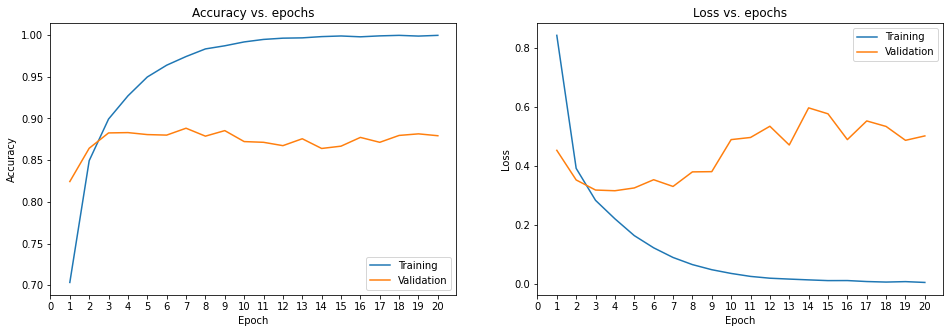

2021-07-21 08:53:39,575: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_ft


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_ft
----------------------------------------evaluate----------------------------------------


2021-07-21 08:54:05,795: INFO: test loss:0.3307
2021-07-21 08:54:05,796: INFO: test accuracy:0.8881
2021-07-21 08:54:05,797: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:54:05,799: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 08:54:05,799: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 08:54:05,804: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-21 08:54:05,846: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.layer/assets


2021-07-21 08:54:06,396: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.layer/assets
2021-07-21 08:54:06,420: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator
2021-07-21 08:54:06,420: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding


----------------------------------------confusion matrix----------------------------------------


2021-07-21 08:54:06,693: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


2021-07-21 08:54:07,001: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


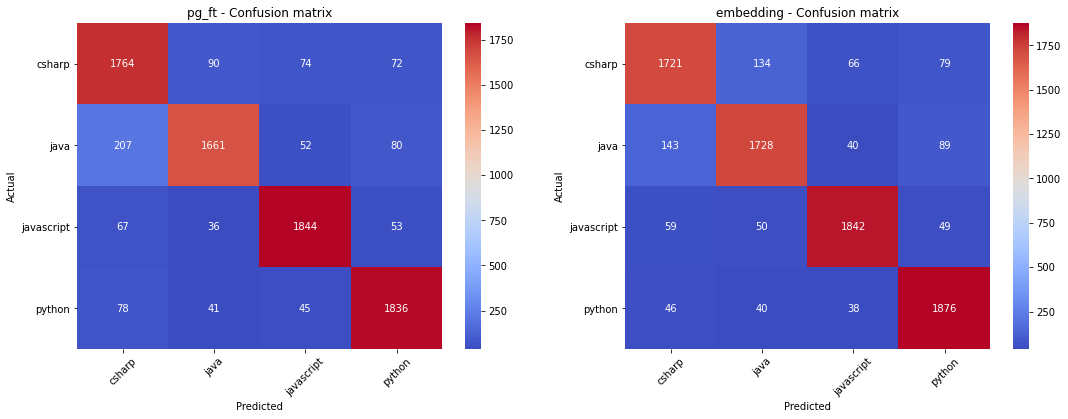

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,embedding,2001604,61.3,0.0421,0.2747,0.9959,0.8959,0.9999,0.9868
2,mlp1,2561284,19.4,0.1675,0.3006,0.9570,0.8920,0.9972,0.9844
3,embedding_ft,3002404,87.8,0.0309,0.2889,0.9989,0.8899,1.0000,0.9856
4,pg_ft,3184644,358.8,0.0439,0.3307,0.9921,0.8881,0.9998,0.9838
5,sepcnn_ft,3056840,102.9,0.0855,0.4741,0.9759,0.8670,0.9989,0.9764
6,pg_default,3184644,341.9,0.0765,0.3757,0.9835,0.8644,0.9992,0.9776
7,mlp2,2561284,17.3,0.1404,0.4293,0.9875,0.8589,0.9997,0.9761
8,sepcnn,2043940,68.9,0.1012,0.5009,0.9691,0.8547,0.9984,0.9736
9,rnn_lstm_ft,4283204,214.6,1.3706,1.3835,0.2668,0.2559,0.5215,0.5053
10,rnn_lstm,3123404,200.6,1.3743,1.3877,0.2625,0.2542,0.5172,0.5056


In [38]:
helper = qtf.classification.Classification(params, model_results=model_results, datasets=sequence_datasets2)
model = qtf.classification.models.pooled_gru1(helper, name='pg_ft', 
                                              embedding_matrix=embedding_matrix_fasttext, 
                                              is_embedding_trainable=True)
model.summary()
history = helper.train(model)
helper.model_summary(model, history=history)

2021-07-21 09:18:58,818: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_ft


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_ft
----------------------------------------evaluate----------------------------------------


2021-07-21 09:19:22,494: INFO: test loss:0.3307
2021-07-21 09:19:22,495: INFO: test accuracy:0.8881
2021-07-21 09:19:22,496: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 09:19:22,498: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json
2021-07-21 09:19:22,498: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


----------------------------------------save model results and generator----------------------------------------


2021-07-21 09:19:22,502: WARNING: Please add `keras.layers.InputLayer` instead of `keras.Input` to Sequential model. `keras.Input` is intended to be used by Functional model.


2021-07-21 09:19:22,544: WARNING: Compiled the loaded model, but the compiled metrics have yet to be built. `model.compile_metrics` will be empty until you train or evaluate the model.


INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.layer/assets


2021-07-21 09:19:23,080: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.layer/assets
2021-07-21 09:19:23,101: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator
2021-07-21 09:19:23,101: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding


----------------------------------------confusion matrix----------------------------------------


2021-07-21 09:19:23,359: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


2021-07-21 09:19:23,674: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


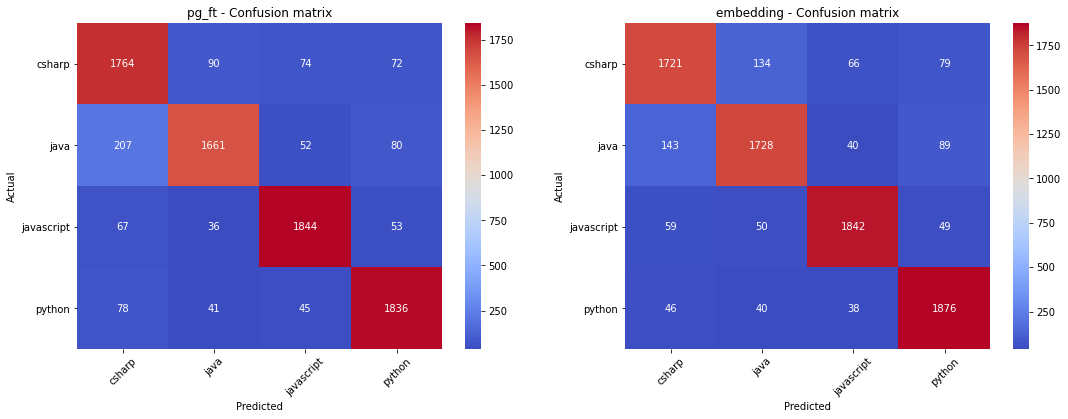

----------------------------------------models----------------------------------------


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,embedding,2001604,61.3,0.0421,0.2747,0.9959,0.8959,0.9999,0.9868
2,mlp1,2561284,19.4,0.1675,0.3006,0.9570,0.8920,0.9972,0.9844
3,embedding_ft,3002404,87.8,0.0309,0.2889,0.9989,0.8899,1.0000,0.9856
4,pg_ft,3184644,358.8,0.0439,0.3307,0.9921,0.8881,0.9998,0.9838
5,sepcnn_ft,3056840,102.9,0.0855,0.4741,0.9759,0.8670,0.9989,0.9764
6,pg_default,3184644,341.9,0.0765,0.3757,0.9835,0.8644,0.9992,0.9776
7,mlp2,2561284,17.3,0.1404,0.4293,0.9875,0.8589,0.9997,0.9761
8,sepcnn,2043940,68.9,0.1012,0.5009,0.9691,0.8547,0.9984,0.9736
9,rnn_lstm_ft,4283204,214.6,1.3706,1.3835,0.2668,0.2559,0.5215,0.5053
10,rnn_lstm,3123404,200.6,1.3743,1.3877,0.2625,0.2542,0.5172,0.5056


In [47]:
helper.model_summary(model, history=history)

## 评估

### 最佳模型

In [39]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2021-07-21 08:54:15,527: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k
2021-07-21 08:54:15,529: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/results.json


,model_name,weight_number,train_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,embedding,2001604,61.3,0.0421,0.2747,0.9959,0.8959,0.9999,0.9868
2,mlp1,2561284,19.4,0.1675,0.3006,0.9570,0.8920,0.9972,0.9844
3,embedding_ft,3002404,87.8,0.0309,0.2889,0.9989,0.8899,1.0000,0.9856
4,pg_ft,3184644,358.8,0.0439,0.3307,0.9921,0.8881,0.9998,0.9838
5,sepcnn_ft,3056840,102.9,0.0855,0.4741,0.9759,0.8670,0.9989,0.9764
6,pg_default,3184644,341.9,0.0765,0.3757,0.9835,0.8644,0.9992,0.9776
7,mlp2,2561284,17.3,0.1404,0.4293,0.9875,0.8589,0.9997,0.9761
8,sepcnn,2043940,68.9,0.1012,0.5009,0.9691,0.8547,0.9984,0.9736
9,rnn_lstm_ft,4283204,214.6,1.3706,1.3835,0.2668,0.2559,0.5215,0.5053
10,rnn_lstm,3123404,200.6,1.3743,1.3877,0.2625,0.2542,0.5172,0.5056


2021-07-21 08:54:15,593: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding
2021-07-21 08:54:15,859: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


2021-07-21 08:54:16,173: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.
2021-07-21 08:54:16,176: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/mlp1
2021-07-21 08:54:16,486: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/ngram_preproess.generator
2021-07-21 08:54:16,574: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/embedding_ft
2021-07-21 08:54:16,877: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


2021-07-21 08:54:17,187: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.
2021-07-21 08:54:17,191: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/pg_ft
2021-07-21 08:54:23,410: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


2021-07-21 08:54:23,737: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.
2021-07-21 08:54:23,741: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sepcnn_ft
2021-07-21 08:54:24,240: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/output/stack-overflow-16k/stack-overflow-16k_0721_p100/sequence_map.generator


2021-07-21 08:54:24,557: WARNING: No training configuration found in save file, so the model was *not* compiled. Compile it manually.


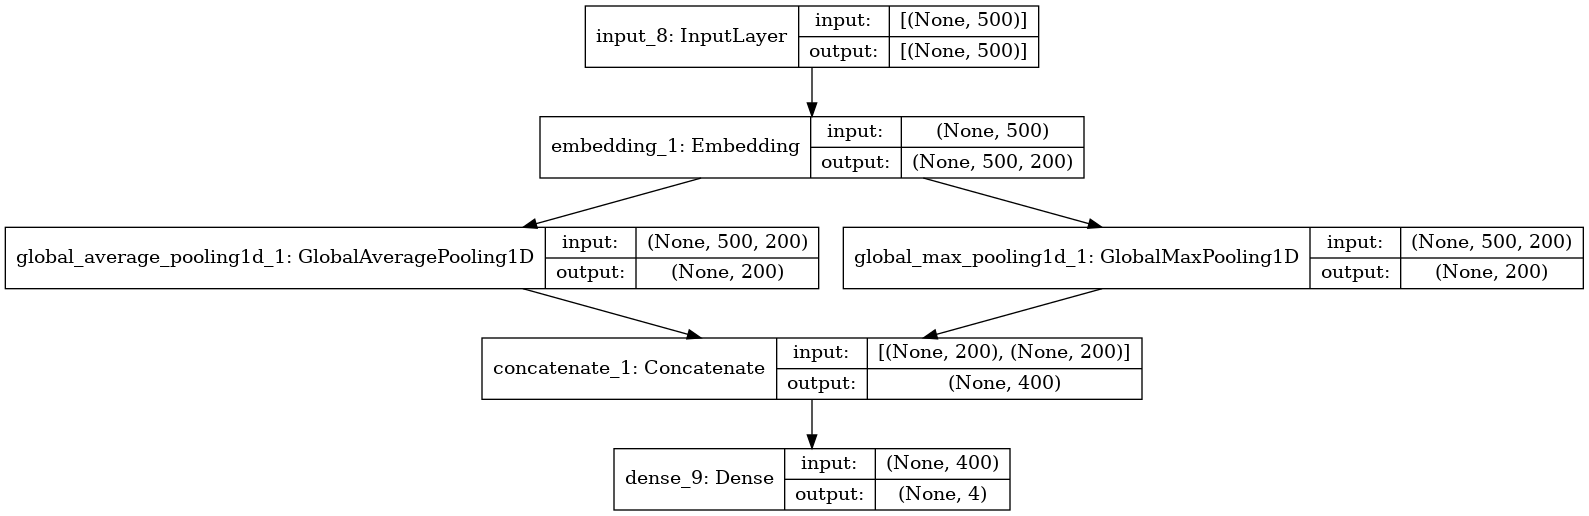

In [40]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

----------------------------------------1. javascript----------------------------------------
"how we can take value from website by using blank code? import urllib.from datetime import date,timedelta.import datetime.import re.list =[""infy.ns"",""grasim.ns"",""idea.ns"",""asianpain.ns"",""bajaj-auto-eq.ns"",.       ""drreddy.ns"",""boschltd.ns"",""kotakbank.ns"",""m&amp;m.ns"",""ultracemc.ns"",.       ""sunpharma.ns"",""lt.ns"",""acc.ns"",""sbin.ns"",""bhartiartl.ns"",.       ""lupin.ns"",""reliance.ns"",""hdfcbank.ns"",""zeel.ns"",""ntpc.ns"",.       ""icicibank.ns"",""cipla.ns"",""tcs.ns"",""bpcl.ns"",""heromotoc.ns""].i=0.while i&lt;len(list):.    url=""http://finance.yahoo.com/q?s=""+list[i]+""&amp;ql=1"".    htmlfile = urllib.urlopen(url).    htmltext=htmlfile.read().    regex='&lt;span id=""yfs_l84_'+list[i]+'""&gt;(.+?)&lt;/span&gt;'.    pattern = re.compile(regex).    price = re.findall(pattern,htmltext).    print(price).    i=i+1...i have to take value from finance.yahoo.com 

2021-07-21 08:54:26,197: WARNING: 5 out of the last 254 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f3325361950> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2021-07-21 08:54:26,453: WARNING: 6 out of the last 255 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f3324968ae8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


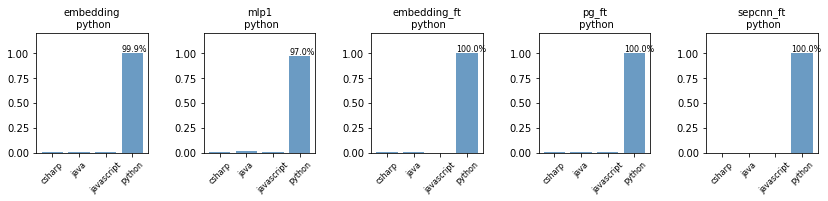

----------------------------------------2. csharp----------------------------------------
mq pure blank client lib i am evaluating websphere mq7.  i am a traditionally a tibrv guy.  one thing i do not like is the fact that the ibm blank client libs require c++ libs in order to run.  is there anyway to run the ibm blank client libs without requiring the c++ libs?  e.g. is there a pure blank client library for mq ?



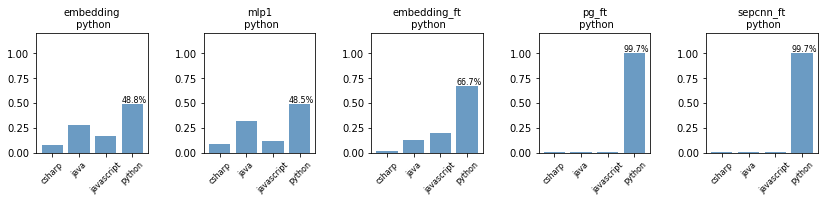

----------------------------------------3. java----------------------------------------
"error while creating runtime object string commclass = ""classa"";.assembly objassembly = assembly.load(""democlasslibrary"");.ia iface = (ia)objassembly.createinstance(commclass);.iface.run();...i am getting null in iface variable..public interface ia.{.    void run();.}.public class classa : ia.{.    string str = string.empty;..    public void run().    {.        console.writeline(""{0}"", datetime.now.ticks);.        logger.logger.createlog(datetime.now.ticks.tostring());.    }.}...above is the class declaration by the namespace democlasslibrary..can u please help me out....thnx"



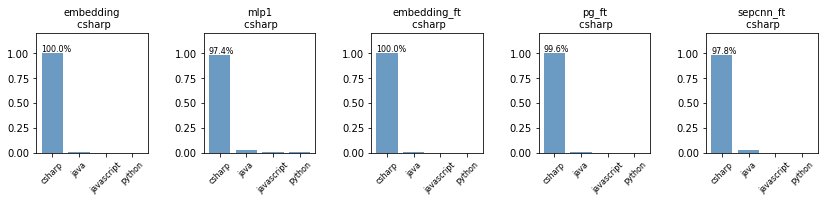

----------------------------------------4. python----------------------------------------
"run blank form app as service i developed blank a gui form with only ""start"" and ""stop"" something like:..private void btnstart_click(object sender, eventargs e).{. //some code here.}..private void btnstop_click(object sender, eventargs e).{.//some code here.}...i need to run this app as service...how can i run my gui app as a service? plz help"



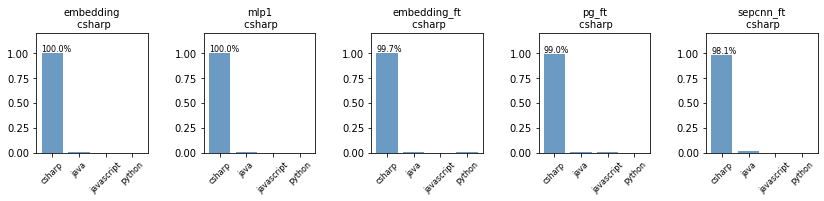

----------------------------------------5. csharp----------------------------------------
"merge objects according to id order in blank i am trying to solve the order of this merged object. a object and b object are combined into one object, but note that the order is based on id...i have two objects and merge objects, but i want to order according to id. ..the out put should be:..[.    {.        ""id"":1,.        ""name"":""apple"".    },.    {.        ""id"":2,.        ""name"":""apple2"".    },.    {.        ""id"":3,.        ""name"":""apple3"".    },.    {.        ""id"":4,.        ""name"":""apple4"".    }.]...my code:....var a = [{.    ""id"": 1,.    ""name"": ""apple"".  },.  {.    ""id"": 2,.    ""name"": ""apple2"".  },..].var b = [{.    ""id"": 3,.    ""name"": ""apple3"".  },.  {.    ""id"": 4,.    ""name"": ""apple4"".  }.]..const result = object.assign(a, b);.console.log(result)"



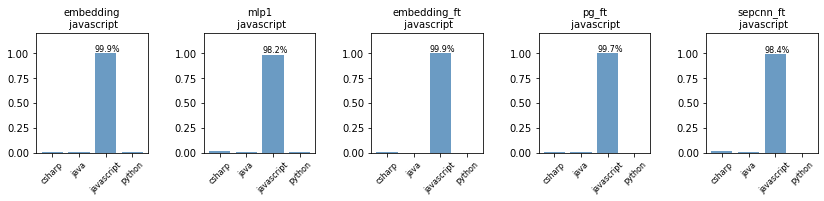

In [41]:
qtf.utils.plot_sample_text_analysis(predictors, test_texts, test_labels,
                                    sample_count=5, show_error_sample=False) 

----------------------------------------1. java----------------------------------------
"from where can we download the blank dlls email, getpass, imaplib, os i am searching to download the blank dlls email, getpass, imaplib, os and use that in vb.net to get the gmail email with attachments"



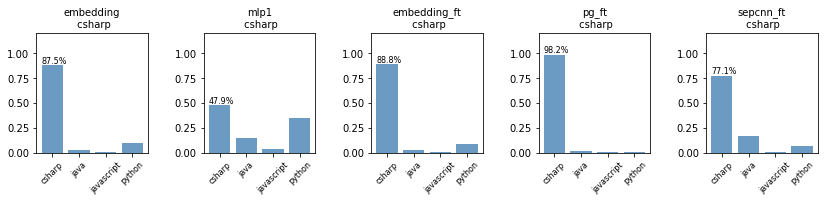

----------------------------------------2. csharp----------------------------------------
"same keyword for two purposes in blank? as we use ""default"" keyword as a access specifier, and it can be used in switch statements as well with complete different purpose, so i was curious that is there any other keywords in blank which can be used in more then one purposes"



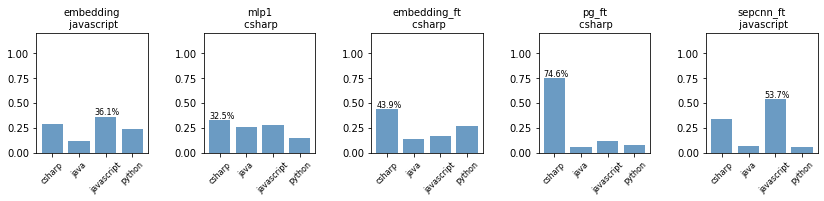

----------------------------------------3. java----------------------------------------
"how to change a string in set<string> during foreach iteration? i have a set of strings that i'd like to iterate over, and change all of those who equal something, to equal something else:..// set&lt;string&gt; strings = new hashset().for (string str : strings) {.  if (str.equals(""foo"")) {.    // how do i change str to equal ""bar""?.  }.}...i've tried replace() which didn't work. i've also tried removing ""str"" and adding the desired string, which caused an error. how would i go about doing this?"



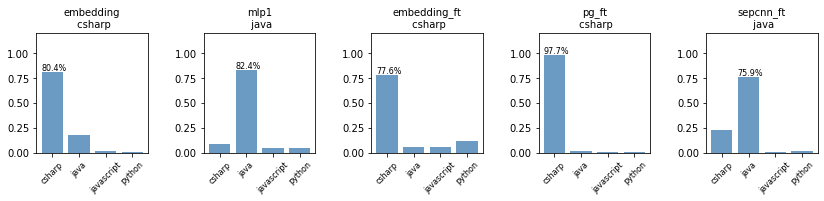

----------------------------------------4. java----------------------------------------
"use class name from properties file as default for factory return i'm new to class name instantiation from properties files. never done that before :) .so, i hava a properties file where to define a class to be used as framework default. for this class, lots of instances should be created through a factory. .whats the best factory implementation to use? i came up through research on google with the factory method and the static factory method pattern...at this point, i do have:..public interface handler { ... }..public class concretehandler1 implements handler { ... }..public class concretehandler2 implements handler { ... }...from the properties file i need to be able to specify:...  default.handler=com.handlers.concretehandler1...the new specified default handler will be instantiated very often to do its job. following this template so far:..public class handlerfactory {.    private static handle

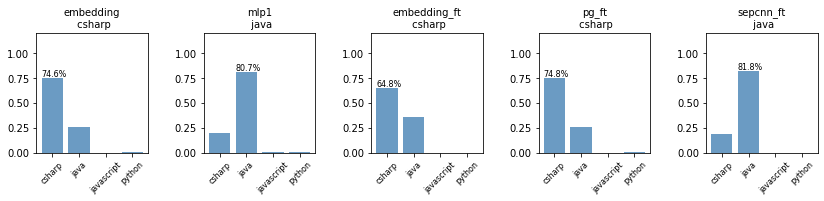

----------------------------------------5. python----------------------------------------
"can i use square brackets to pull a value from a class i have a class that has the variable ""magic"". this is a 4 char string. can i do something like this in blank?..string offset = chunklist[""_blf""].offset;...*assume that ""chunklist"" is an ilist/list of ""chunk"" objects."



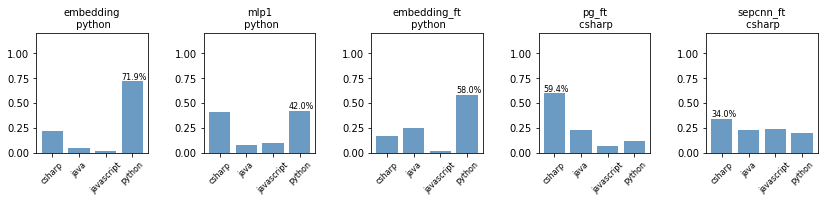

In [42]:
qtf.utils.plot_sample_text_analysis(predictors, test_texts, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [43]:
results = best_predictor.evaluate(test_texts, test_labels)
print(results)

predictions = best_predictor.predict(test_texts)
print(predictions.shape)

{'loss': 0.2746846377849579, 'accuracy': 0.8958749771118164, 'mae': 4.749466896057129}
(8000, 4)


In [44]:
top1_predictions = best_predictor.predict_top_k(test_texts, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

,precision,recall,f1
csharp,0.874048,0.8605,0.867221
java,0.885246,0.8640,0.874494
javascript,0.927492,0.9210,0.924235
python,0.896321,0.9380,0.916687


----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

      csharp     0.8740    0.8605    0.8672      2000
        java     0.8852    0.8640    0.8745      2000
  javascript     0.9275    0.9210    0.9242      2000
      python     0.8963    0.9380    0.9167      2000

    accuracy                         0.8959      8000
   macro avg     0.8958    0.8959    0.8957      8000
weighted avg     0.8958    0.8959    0.8957      8000



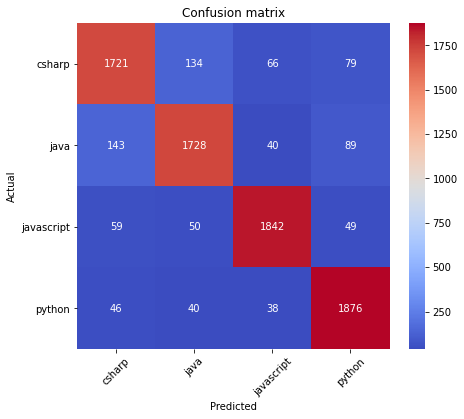

In [45]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)